# **Practical 3: Imaging Using Structured Light**

ID5220: Biomedical Imaging and Sensing

2D Super-Resolution Structured Illumination Microscopy (SR-SIM)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.signal import fftconvolve
from scipy.ndimage import fourier_shift
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
import imageio.v3 as iio
from pathlib import Path

# **1. Copilo-Verification**

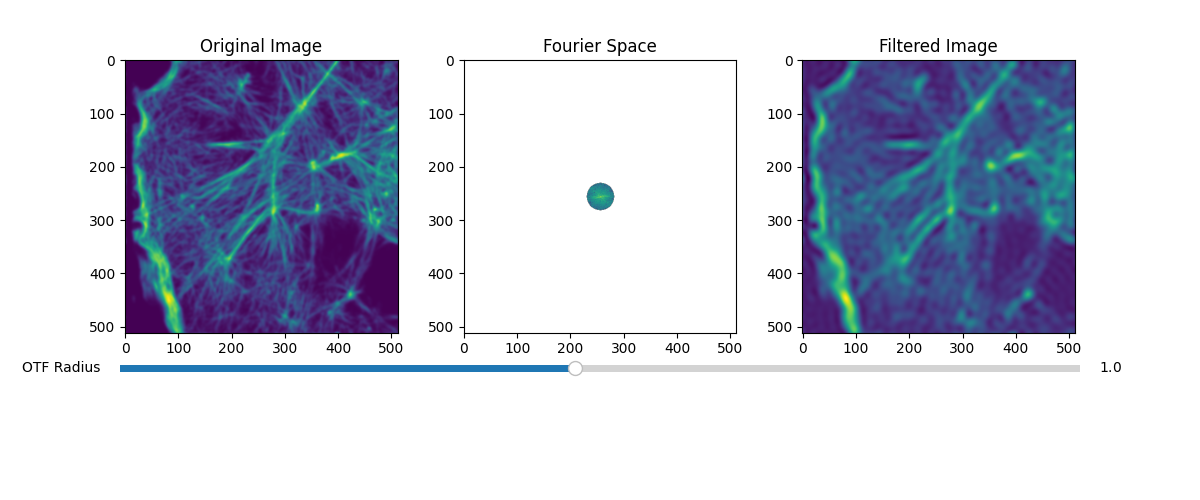

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib import gridspec
from matplotlib.colors import LogNorm
from skimage import io

# Use %matplotlib widget for interactive plots
%matplotlib widget

# Load the image into a NumPy array
image = io.imread('example_image.png', as_gray=True)

# Build x, y meshgrid matching the image dimensions
x = np.linspace(-10, 10, image.shape[1])
y = np.linspace(-10, 10, image.shape[0])
X, Y = np.meshgrid(x, y)

# Create the figure and axes
fig = plt.figure(figsize=(12, 5))
# 2 rows × 3 cols: top for images, bottom (thin) for slider
gs = gridspec.GridSpec(2, 3,
                       height_ratios=[1, 0.05],
                       width_ratios=[1, 1, 1])

ax_image    = fig.add_subplot(gs[0, 0])
ax_fourier  = fig.add_subplot(gs[0, 1])
ax_filtered = fig.add_subplot(gs[0, 2])
# slider spans all three columns on the bottom row
ax_slider   = fig.add_subplot(gs[1, :])

# Display the original image
ax_image.imshow(image) # it gave cmap gray but i deleted it for aesthetic purposes
ax_image.set_title('Original Image')

# Compute the Fourier transform of the image
fft_image = np.fft.fftshift(np.fft.fft2(image))

# Initialize the slider
slider = Slider(ax_slider, 'OTF Radius', 0.1, 2, valinit=1, orientation='horizontal')

# Update function to refresh the display
def update(val):
    radius = slider.val
    
    # Apply the circular mask
    mask = X**2 + Y**2 < radius**2
    fft_image_masked = fft_image * mask
    
    # Handle divide-by-zero warnings for the log display
    log_magnitude = np.log(np.abs(fft_image_masked) + 1e-10)
    
    # Perform the inverse Fourier transform
    filtered_image = np.fft.ifft2(np.fft.ifftshift(fft_image_masked)).real
    
    # Clear and redraw all three axes
    ax_image.clear()
    ax_image.imshow(image) # it gave cmap gray but i deleted it for aesthetic purposes
    ax_image.set_title('Original Image')
    
    ax_fourier.clear()
    ax_fourier.imshow(log_magnitude, norm=LogNorm())
    ax_fourier.set_title('Fourier Space')
    
    ax_filtered.clear()
    ax_filtered.imshow(filtered_image)
    ax_filtered.set_title('Filtered Image')
    
    fig.canvas.draw_idle()

# Call the update function once to initialize the display
update(None)

# Assemble the figure canvas, slider, and button into a vertical layout
plt.subplots_adjust(left=0.1, bottom=0.25)

# Connect the slider to the update function
slider.on_changed(update)

# Display the figure
plt.show()


In [3]:
# Otherwise the %matplotlib widget messes up all my other figures
%matplotlib inline

# Also I don't understand why the notebook outputs the slider etc. again in the next section. -> Run section 2 again individually after all is run.

# **2. Copilot SR-SIM Retrieval Algorithm**

In [4]:
def modulate_image(image, grating):
    if image.shape != grating.shape:
        raise ValueError("Image and grating must have the same shape.")
    return image * grating

def fourier_transform_image(modulated_image):
    return np.fft.fft2(modulated_image)

def shift_and_recombine(fourier_images, shifts):
    if len(fourier_images) != len(shifts):
        raise ValueError("Number of Fourier images must match number of shifts.")
    
    recombined_image = np.zeros_like(fourier_images[0])
    for image, (dx, dy) in zip(fourier_images, shifts):
        shifted_image = np.roll(image, shift=(dx, dy), axis=(0, 1))
        recombined_image += shifted_image
    
    return recombined_image

def filter_recombined_image(recombined_image, filter_kernel):
    if recombined_image.shape != filter_kernel.shape:
        raise ValueError("Recombined image and filter kernel must have the same shape.")
    
    return recombined_image * filter_kernel

def inverse_fourier_transform_image(filtered_image):
    return np.abs(np.fft.ifft2(filtered_image))

def sim_reconstruct(image, grating, shifts, filter_kernel):
    modulated_image = modulate_image(image, grating)
    modulated_image = modulated_image + np.random.normal(loc=0.0, scale=0.01, size=modulated_image.shape)
    fourier_image = fourier_transform_image(modulated_image)
    recombined_image = shift_and_recombine([fourier_image], shifts)
    filtered_image = filter_recombined_image(recombined_image, filter_kernel)
    reconstructed_image = inverse_fourier_transform_image(filtered_image)
    
    return reconstructed_image, modulated_image # added modulated image myself for testing later

def display_sim_reconstruction(image_path):

    # 1) Load image
    image = imread(image_path, as_gray=True)

    # 2) Define SIM parameters *inside* the function
    grating = np.exp(1j * np.random.rand(*image.shape))  # random complex grating
    shifts = [(10, 20)]                                   # example shift
    filter_kernel = np.ones(image.shape)                 # identity filter

    # 3) Run your simple SIM
    recon, modulated = sim_reconstruct(image, grating, shifts, filter_kernel)

    # 4) Plot Original ∣ Modulated ∣ Reconstructed
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title('Original Image' , fontsize=20)
    axes[0].axis('off')

    axes[1].imshow(np.abs(modulated))
    axes[1].set_title('Modulated Image', fontsize=20)
    axes[1].axis('off')

    axes[2].imshow(recon)
    axes[2].set_title('Reconstructed Image', fontsize=20)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

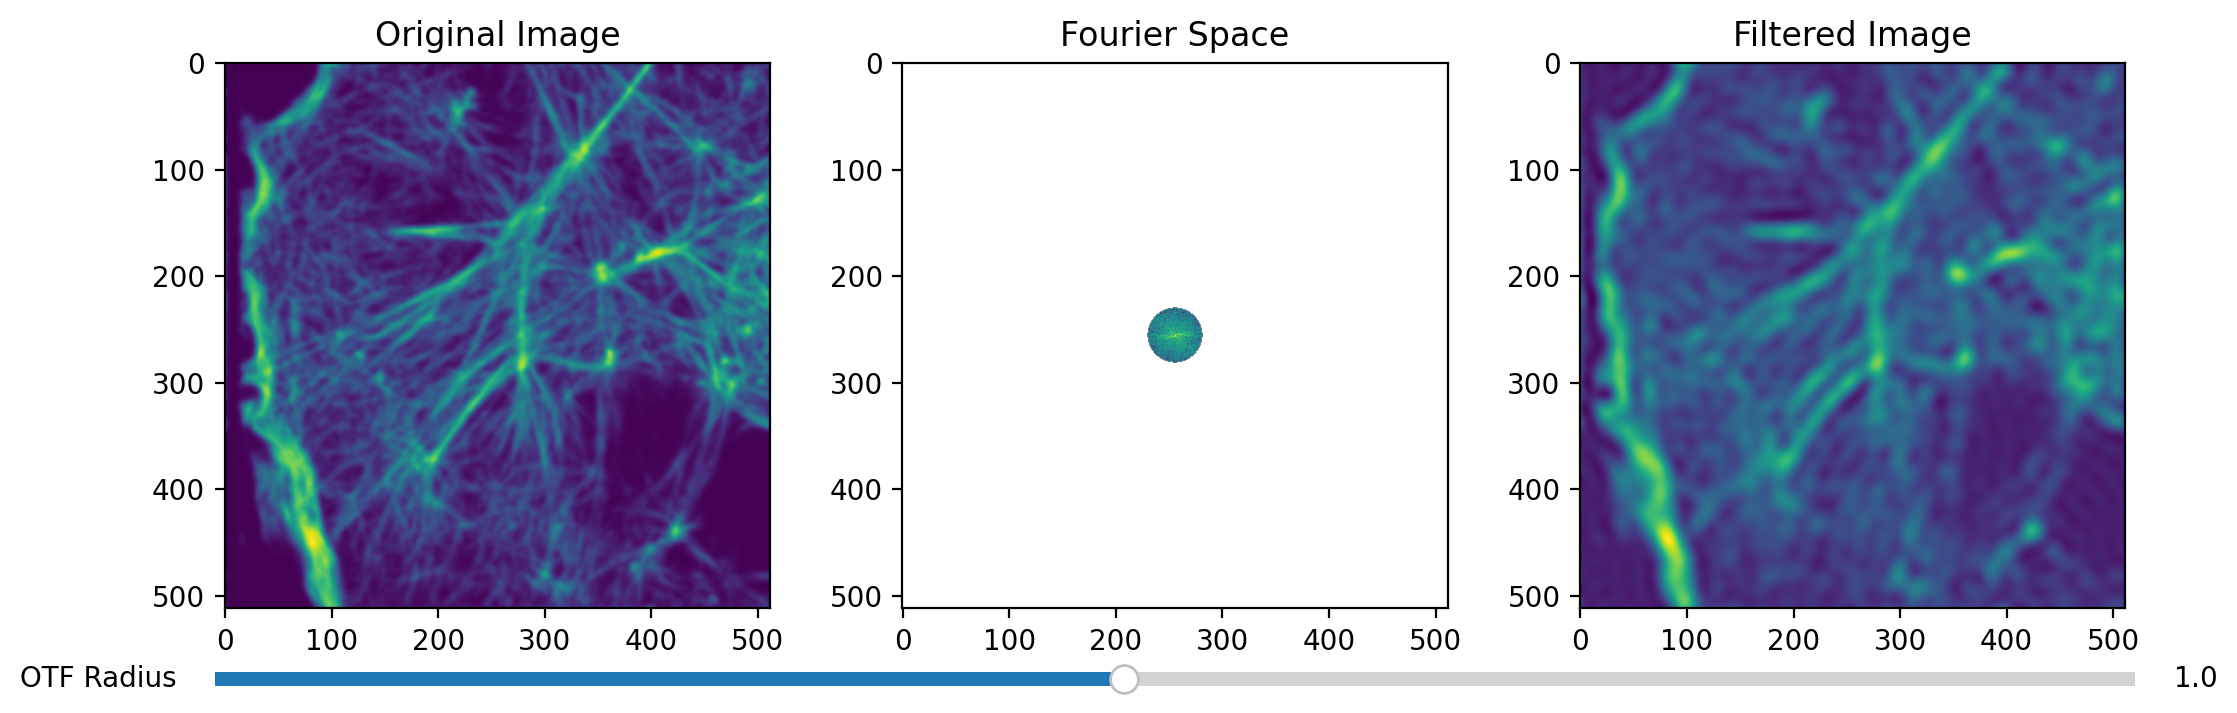

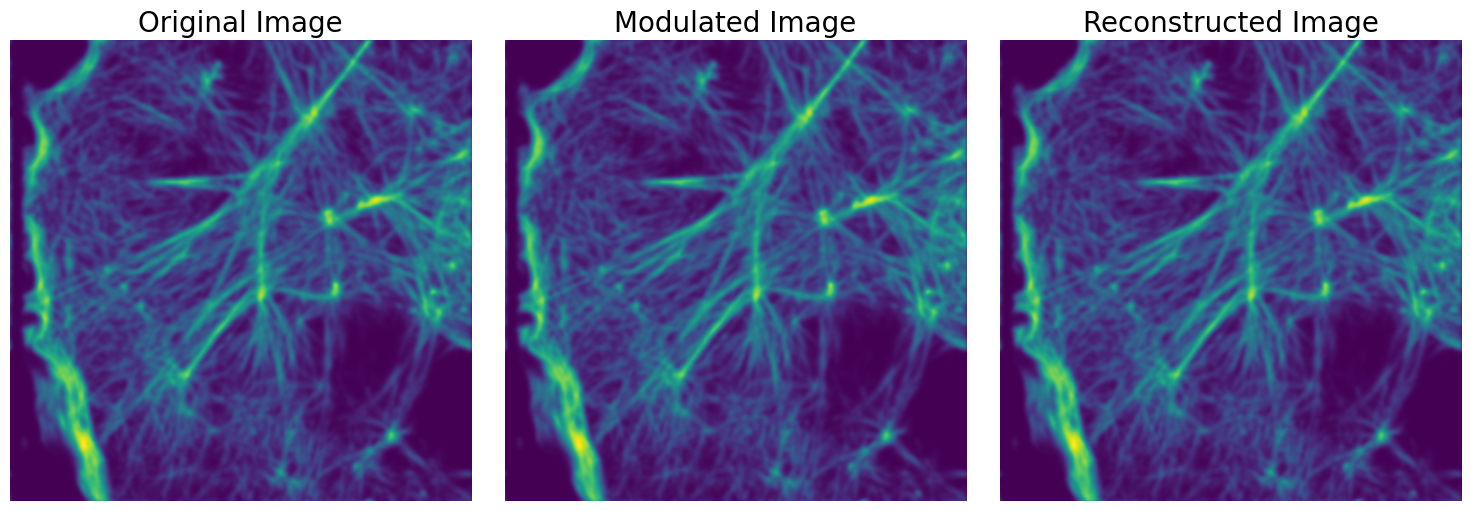

In [5]:
display_sim_reconstruction('example_image.png')

# **3. Testing Copilot SIM-Retrieval Algorithm**

### **3.1 Helper Functions**

In [ ]:
# Plot log-magnitude FFT image for visual confirmation of algorithm
# Nicely shows noise eg. if magnitude is bigger than orginal image something must have gone wrong 
# So even if algorithm performs well on some tests, I can judge if this is due to noise
def show_fft(img, title, ax):
    # Compute centered FFT
    F   = np.fft.fftshift(np.fft.fft2(img))
    # Log magnitude for dynamic-range compression
    mag = np.log10(np.abs(F) + 1e-10)
    # Normalize to [0,1] for display
    mag = (mag - mag.min()) / (mag.max() - mag.min())
    # Show with perceptual colormap
    ax.imshow(mag, cmap='inferno')
    # Axis housekeeping
    ax.set_title(title, fontsize=20); ax.axis('off')


# Define function to compute the radial power-spectral density (PSD)
def radial_psd(img):
    # Shift FFT so zero-freq is centered, then compute 2-D FFT of zero-mean image
    F = np.fft.fftshift(np.fft.fft2(img - img.mean()))
    # Square magnitude gives power spectrum
    psd = np.abs(F)**2
    # Get image size
    ny, nx = img.shape
    # Build coordinate grid for radial binning
    y, x = np.indices((ny, nx))
    # Radius from center for each pixel (integer bins)
    r = np.hypot(y-ny//2, x-nx//2).astype(int)
    # Sum power in each radius ring
    sum_r = np.bincount(r.ravel(), psd.ravel())
    # Count pixels per ring
    ctr_r = np.bincount(r.ravel())
    # Return average power per radius
    return sum_r / np.maximum(ctr_r, 1)

# For a PSD find spatial-frequency cut-off where signal equals noise
def k_cut_from_psd(psd, *, outer_frac=0.1, r_min=2):
    # Decide where to measure noise: outer_frac of highest frequencies
    N = len(psd)
    k_noise = int((1-outer_frac)*N)
    # Average PSD beyond k_noise approximates noise floor
    noise = psd[k_noise:].mean()
    # First radius where PSD drops below noise, avoid very center r_min
    idx = np.where(psd[r_min:] < noise)[0]
    # Return cut-off index
    # Fallback to Nyquist-1 if never below noise
    return idx[0]+r_min if idx.size else N-1

# Compute 2-D Fourier ring correlation (FRC) between 2 images
def frc(img1, img2):
    # Centered FFTs of zero-mean images
    F1 = np.fft.fftshift(np.fft.fft2(img1 - img1.mean()))
    F2 = np.fft.fftshift(np.fft.fft2(img2 - img2.mean()))
    # Cross-power spectrum numerator
    prod = F1 * F2.conj()
    # Individual power spectra denominators
    psd1, psd2 = np.abs(F1)**2, np.abs(F2)**2
    # Radius grid for binning
    ny, nx = img1.shape
    y, x = np.indices((ny, nx))
    r = np.hypot(y-ny//2, x-nx//2).astype(int)
    # Bin numerator & denominator by radius
    num = np.bincount(r.ravel(), prod.real.ravel())
    den = np.sqrt(np.bincount(r.ravel(), psd1.ravel()) *
                  np.bincount(r.ravel(), psd2.ravel()))
    # Return FRC curve
    return num / (den + 1e-20)

# Find frequency where FRC curve drops below 1/2-bit threshold (is roughly 0.2071)
def frc_cutoff(img1, img2, threshold=0.2071):
    # Compute FRC curve
    curve = frc(img1, img2)
    # First index where FRC < threshold
    idx = np.argmax(curve < threshold)
    # If never below threshold, return last index
    return idx if idx > 0 else len(curve)-1

# Plot FRC curve
def plot_frc_curve(img1, img2, label='Reconstruction'):
    # Get FRC curve
    curve = frc(img1, img2)
    # Normalize frequency axis (Nyquist = 1)
    Ny, Nx = img1.shape
    freq = np.arange(curve.size) / (min(Ny, Nx) / 2)
    # New figure
    plt.figure()
    # Plot FRC vs frequency
    plt.plot(freq, curve)
    # Make 1/2-bit threshold line
    plt.axhline(0.2071, color='purple', linestyle='--', label='1/2-bit threshold')
    # Labels & title
    plt.xlabel('Normalized spatial frequency (cycles/pixel)', fontsize=18)
    plt.ylabel('FRC', fontsize=18)
    plt.title(f'FRC curve for {label}', fontsize=20)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.show()

# I'm already using this self-made propper function to test the copilot code
# Image loader that handles colour with gray conversion & normalisation to [0,1]
# Want it to handle colour as I tested algorithm on all kinds of funny images
def setup_and_load_image(path): 
    # Read image from disk
    img = imread(path)
    # If RGB/RGBA, convert to grayscale
    if img.ndim == 3:
        img = rgb2gray(img)
    # Integer images need scaling to [0,1]
    if np.issubdtype(img.dtype, np.integer):
        img = img.astype(np.float32) / np.iinfo(img.dtype).max
    else:
        # Ensure floating data clipped to valid range
        img = np.clip(img.astype(np.float32), 0, 1)
    # Return processed image
    return img


### **3.2 Test Pipeline**

In [7]:
# Function to run and test Copilot's SIM reconstruction
# Runs Copilot's single-frame SIM with tiny noise, then:
# Radial PSD on modulated vs reconstruction
# examines spectral content & resolution via PSD and independent-stack FRC
def test_copilot_sim_reconstruct(image_path):

    # Load & reconstruct
    gt = setup_and_load_image(image_path)
    grating    = np.exp(1j * np.random.rand(*gt.shape))
    shifts     = [(10, 20)]
    filt_kernel = np.ones(gt.shape)
    recon, mod = sim_reconstruct(gt, grating, shifts, filt_kernel)

    # Visualise FFT
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    show_fft(gt,  'GT FFT',        ax[0])
    show_fft(mod, 'Modulated FFT', ax[1])
    show_fft(recon,'Reconstructed FFT',ax[2])
    plt.tight_layout(); plt.show()

    # Radial PSD cut-offs
    k_mod = k_cut_from_psd(radial_psd(mod))
    k_rec = k_cut_from_psd(radial_psd(recon))
    print('Noise-floor crossing (radial PSD):')
    print(f'  Modulated frame:     k = {k_mod}')
    print(f'  Reconstruction:      k = {k_rec}    ({k_rec/k_mod:.2f}x)')

    # Independent-stack FRC
    # Generate two independent noisy SIM runs (A & B)
    grating_A = np.exp(1j * np.random.rand(*gt.shape))
    recon_A, mod_A = sim_reconstruct(gt, grating_A, shifts, filt_kernel)
    grating_B = np.exp(1j * np.random.rand(*gt.shape))
    recon_B, mod_B = sim_reconstruct(gt, grating_B, shifts, filt_kernel)

    # FRC of the two raw SIM frames
    # take abs() since mod_A/B are complex
    k_frc_mod = frc_cutoff(np.abs(mod_A), np.abs(mod_B))

    # FRC of the two reconstructions
    k_frc_rec = frc_cutoff(recon_A, recon_B)

    # Resolution gain = how much farther the reconstructions correlate
    gain = k_frc_rec / k_frc_mod

    print('\nIndependent-stack FRC 1/2-bit cut-offs:')
    print(f'  Modulated A vs B: 1/{k_frc_mod} px')
    print(f'  Recon A vs B:     1/{k_frc_rec} px')
    print(f'  Resolution gain:  {gain:.2f}x')
    
    # Plot those curves too
    plot_frc_curve(np.abs(mod_A), np.abs(mod_B), label='Mod A vs B')
    plot_frc_curve(recon_A, recon_B,     label='Recon A vs B')

    # Return results
    return {
        'k_psd_mod':     k_mod,
        'k_psd_rec':     k_rec,
        'psd_gain':      k_rec / k_mod,
        'k_frc_modAB':   k_frc_mod,
        'k_frc_recAB':   k_frc_rec,
        'frc_gain_AB':   gain
    }

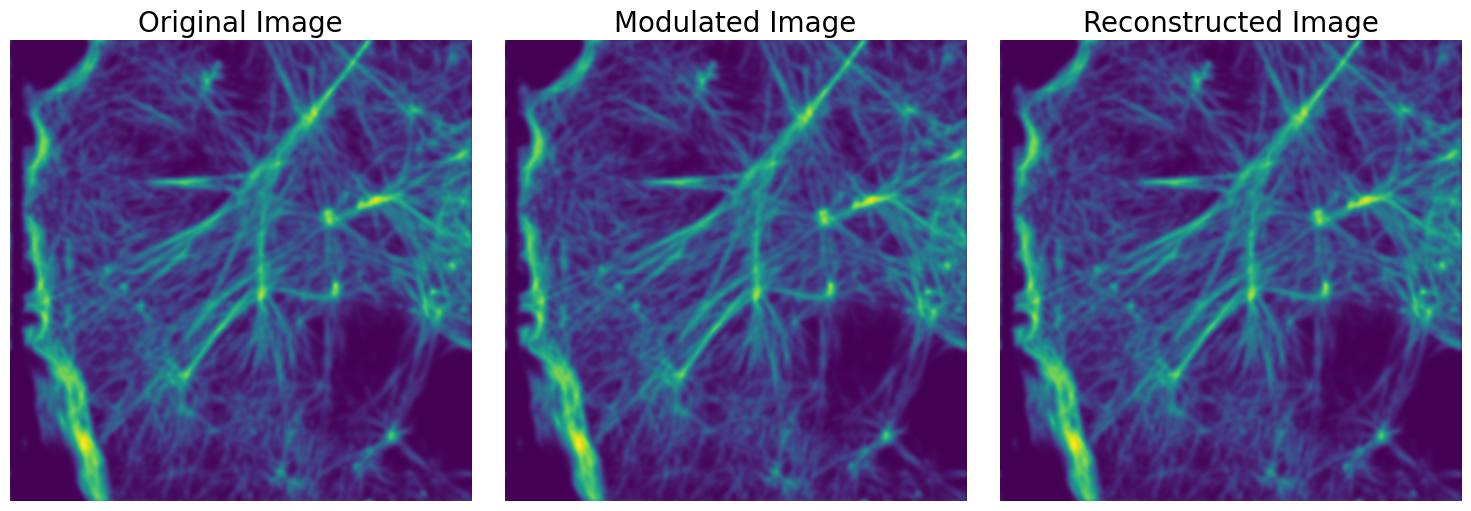

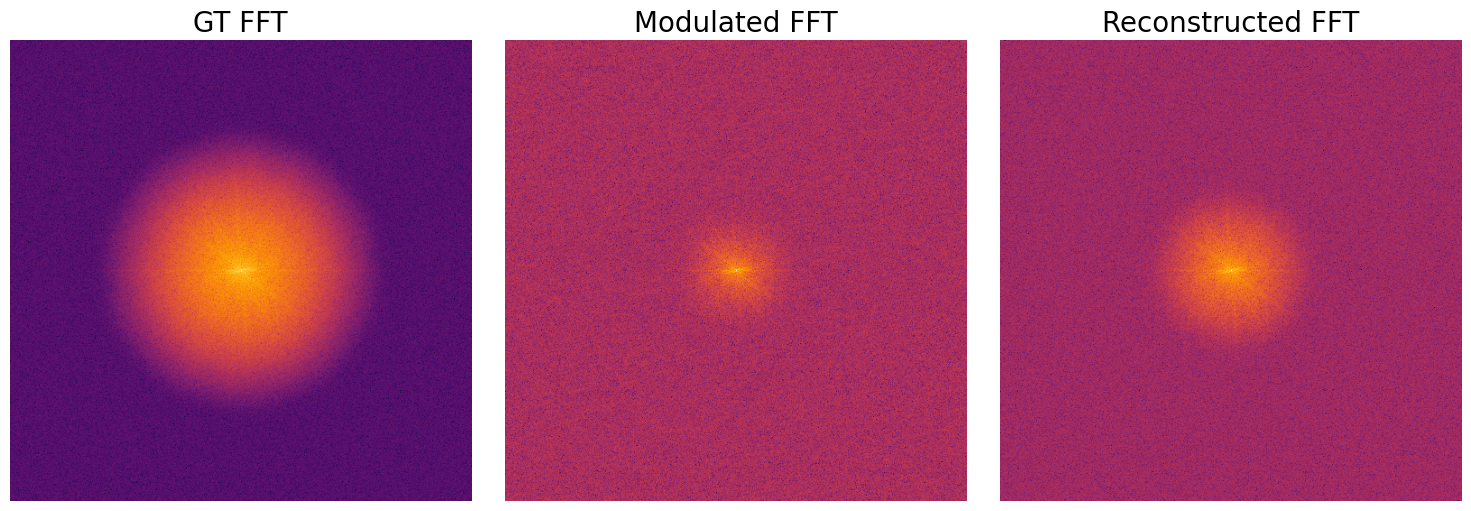

Noise-floor crossing (radial PSD):
  Modulated frame:     k = 70
  Reconstruction:      k = 117    (1.67x)

Independent-stack FRC 1/2-bit cut-offs:
  Modulated A vs B: 1/362 px
  Recon A vs B:     1/362 px
  Resolution gain:  1.00x


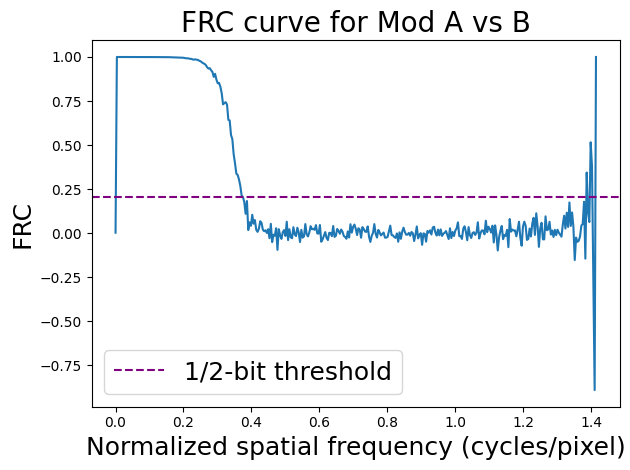

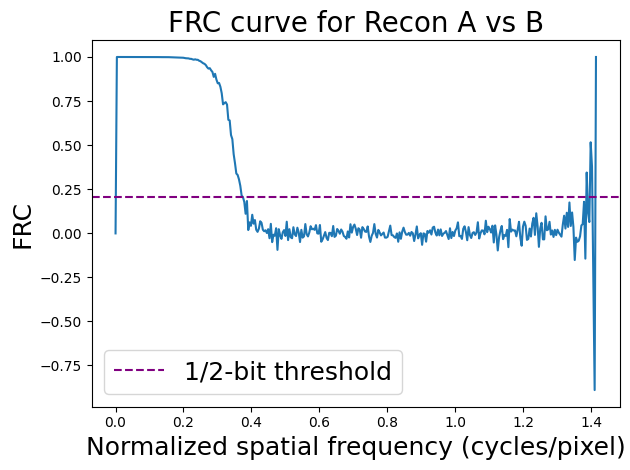

{'k_psd_mod': 70,
 'k_psd_rec': 117,
 'psd_gain': 1.6714285714285715,
 'k_frc_modAB': 362,
 'k_frc_recAB': 362,
 'frc_gain_AB': 1.0}

In [8]:
# Run Copilot pipeline
display_sim_reconstruction('example_image.png')

# Test Copilot pipeline
test_copilot_sim_reconstruct('example_image.png')

**The Independent-stack FRC 1/2-bit cut-offs are subject to randomness, but I've run it many times at it always shows 0 resolution gain.**

# **4. My Version of SR-SIM Retrieval**

### **4.1 Helper Functions**

In [9]:

# Rescale / stretch intensities to full [0,1] range
def rescale(img):
    # Shift minimum to zero
    img = img - img.min()
    # Divide by dynamic range with tiny epsilon
    return (img / (img.max() + 1e-20)).astype(np.float32)

# Build a Gaussian point-spread function (PSF) matching microscope blur
def define_psf(shape, sigma_px):
    # Unpack dimensions
    m, n = shape
    # Coordinate axes centered at 0
    y = np.arange(-m//2, m//2)
    x = np.arange(-n//2, n//2)
    # Meshgrid for 2-D Gaussian
    X, Y = np.meshgrid(x, y)
    # Gaussian formula
    psf = np.exp(-(X**2 + Y**2) / (2*sigma_px**2))
    # Normalise PSF energy to 1
    psf /= psf.sum()
    # Return as float32
    return psf.astype(np.float32)

# I ended up not really using a specified rng, 
# I think many iterations are more statistically significant
def simulate_widefield(img, psf, gaussian_std=0.01, photons=1e4, rng=None):
    # Ensure RNG instance for reproducibility
    rng = np.random.default_rng() if rng is None else rng
    # Convolve GT with PSF (Fourier-efficient)
    blurred = fftconvolve(img, psf, mode='same')
    # Replace NaNs from convolution edges
    blurred = np.nan_to_num(blurred, nan=0.0)
    # Scale to expected photon counts
    lam = np.clip(blurred, 0, None) * photons
    # Poisson shot noise
    shot = rng.poisson(lam) / photons
    # Add Gaussian camera noise
    noisy = shot + rng.normal(0, gaussian_std, img.shape)
    # Clip to valid range
    return np.clip(noisy, 0, 1).astype(np.float32)

# Generate harmonic SIM illumination patterns at multiple angles & phases
# k_px is spatial freq (cycles/px)
# Initially i used 3 phases, but 5 phases improved results
def generate_sim_patterns(shape, k_px, modulation=0.8, num_angles=3, num_phases=5):
    # Image dimensions
    rows, cols = shape
    # Pixel grids
    y = np.arange(rows)
    x = np.arange(cols)
    X, Y = np.meshgrid(x, y)
    # Container for patterns
    patt = []
    # Loop over illumination angles
    for a in range(num_angles):
        # Angle in radians
        theta = a * np.pi / num_angles
        # k-vector components, cycles per pixel
        kx = k_px * np.cos(theta)          
        ky = k_px * np.sin(theta)
        # Loop over phase shifts
        for p in range(num_phases):
            # Phase offset
            phi = p * 2*np.pi / num_phases
            # Argument of cosine grating
            arg = 2*np.pi * (kx * X + ky * Y) + phi
            # Add pattern: 1 + modulation*cos(...)
            patt.append((1 + modulation * np.cos(arg)).astype(np.float32))
    # Return list of illumination frames
    return patt

# Get raw SIM image stack by applying patterns, blurring and adding noise
# Again didn'T end up specifying rng
def simulate_sim_raw(gt, patterns, psf, gaussian_std=0.01, photons=1e4, rng=None):
    # RNG for noise
    rng = np.random.default_rng() if rng is None else rng
    frames = []
    # Iterate over illumination patterns
    for patt in patterns:
        # Multiply GT by pattern (structured illumination)
        illum = gt * patt
        # Blur by PSF (objective + detector)
        blurred = fftconvolve(illum, psf, mode='same')
        blurred = np.nan_to_num(blurred, nan=0.0)
        # Poisson photon statistics
        lam = np.clip(blurred, 0, None) * photons
        shot = rng.poisson(lam) / photons
        # Add Gaussian read noise
        noisy = shot + rng.normal(0, gaussian_std, gt.shape)
        # Clip and store
        frames.append(np.clip(noisy, 0, 1).astype(np.float32))
    # Return stack (N, Y, X)
    return np.stack(frames)

# Normalise SIM frames to [0,1]
# Record background + scale for later
def preprocess_sim_frames(frames):
    # Background estimate: global minimum
    bg = frames.min()
    # Scale factor: peak minus background
    scale = frames.max() - bg
    # Normalise stack
    proc = (frames - bg) / scale
    # Clip for safety
    return np.clip(proc, 0, 1).astype(np.float32), bg, scale

# Function fo mirror-padding, reflect-pad images to reduce ringing when doing FFT shifts
# Also needs to work for 3D because in SIM pipeline I'm padding an entire stack of frames
def mirror_pad(img_stack, pad_frac=0.5):
    # Distinguish stack vs single image
    if img_stack.ndim == 3:
        # Stack dims
        N, ny, nx = img_stack.shape
        # Calculate pad sizes as fraction of original dims
        py, px = int(ny*pad_frac), int(nx*pad_frac)
        # Pad with reflection
        return np.pad(img_stack, ((0,0),(py,py),(px,px)), mode='reflect'), (py, px)
    else:
        ny, nx = img_stack.shape
        py, px = int(ny*pad_frac), int(nx*pad_frac)
        return np.pad(img_stack, ((py,py),(px,px)), mode='reflect'), (py, px)

# Demodulate SIM raw stack into DC and +-1 side-bands for each angle
# Separates frequency components so they can later be re-centered
def reconstruct_fft_components_roll(frames, k_px, *, num_angles, num_phases):

    # Image size
    Ny, Nx = frames[0].shape
    # Compute FFT of each raw frame
    Ffts = [np.fft.fft2(f) for f in frames]
    # Container for components
    comps = []

    # Loop over angles
    for a in range(num_angles):
        # Slice block of current angle, num_phases frames
        blk = Ffts[a*num_phases : (a+1)*num_phases]
        # Compute 0th Fourier coefficient, average across phases
        F0 = sum(blk) / num_phases
        # +1 and −1 coefficients
        Fp = sum(blk[p] * np.exp(-1j*2*np.pi*p/num_phases)
                 for p in range(num_phases)) / num_phases
        Fm = sum(blk[p] * np.exp( 1j*2*np.pi*p/num_phases)
                 for p in range(num_phases)) / num_phases
        # Calculate integer pixel shifts to re-center side-bands
        theta = a * np.pi / num_angles
        kx =  k_px * np.cos(theta)        # cycles/px
        ky =  k_px * np.sin(theta)
        shift_x = int(np.round(kx * Nx))  # DFT bins
        shift_y = int(np.round(ky * Ny))
        # Roll side-bands to origin
        Fp_shifted = np.roll(Fp, (-shift_y, -shift_x), axis=(0, 1))
        Fm_shifted = np.roll(Fm, ( shift_y,  shift_x), axis=(0, 1))
        # Store tuple of components plus shift info
        comps.append((F0, Fp_shifted, Fm_shifted, shift_x, shift_y))

    # Return list for later recombination
    return comps

# Simple sum reconstruction without OTF weighting from demodulated comps
def simple_sim_reconstruct(frames, k_px, psf, *, num_angles, num_phases, modulation):
    # Weighting: DC band gets 1, side-bands need 1/(2*m) to normalise contrast
    coeff_DC = 1.0
    coeff_SB = 1.0 / (2.0 * modulation)
    # Demodulate into frequency components
    comps = reconstruct_fft_components_roll(frames, k_px, num_angles=num_angles, num_phases=num_phases)
    # Accumulator for combined spectrum
    acc = np.zeros(psf.shape, np.complex64)
    # Loop through each angle’s components
    for F0, Fp, Fm, *_ in comps:     # ignore shift info
        acc += coeff_DC * F0 + coeff_SB * (Fp + Fm)
    # Average over angles to reduce noise
    acc /= len(comps)
    # Inverse FFT to get spatial image, cast to float32
    return np.real(np.fft.ifft2(acc)).astype(np.float32)

# Wiener-filter reconstruction uses OTF for deconvolution and noise control
def sim_reconstruct_wiener(frames, k_px, psf, *, num_angles, num_phases, modulation, eps):

    # Relative weights like simple sum
    w0 = 1.0
    w1 = 1.0 / (2.0 * modulation)
    # Optical transfer function (OTF) = FFT of PSF
    OTF = np.fft.fft2(np.fft.ifftshift(psf), s=psf.shape)
    # Demodulate components
    comps = reconstruct_fft_components_roll(frames, k_px, num_angles=num_angles, num_phases=num_phases)
    # Accumulator for Wiener-filtered spectrum
    acc = np.zeros_like(OTF, dtype=np.complex64)

    # Loop through angles
    for F0, Fp, Fm, sx, sy in comps:        # include shift info
        # Wiener filter for DC band
        W0 = np.conj(OTF) / (np.abs(OTF)**2 + eps)
        # Side-band filters rolled to match shifted spectra
        Wp = np.roll(W0, (-sy, -sx), axis=(0, 1))
        Wm = np.roll(W0, ( sy,  sx), axis=(0, 1))
        # Accumulate weighted, filtered components
        acc += w0 * (F0 * W0) + w1 * (Fp * Wp + Fm * Wm)
    
    # Normalise by total weights to keep brightness consistent
    acc /= num_angles * (w0**2 + 2*w1**2)

    # Return spatial domain image
    return np.real(np.fft.ifft2(acc)).astype(np.float32)

### **4.2 Pipeline to run and Test SR-SIM**

In [25]:

# Full pipeline from import of Ground truth to reconstructions and testing
def sim_pipeline(image_path, sigma_px=2.0, modulation=0.8, num_angles=3, num_phases=5, gaussian_std=0.01, photons=1e4, eps=0.01, display=True):
    
    # Load ground truth
    gt  = setup_and_load_image(image_path)
    # Build PSF and derive frequency parameters
    psf    = define_psf(gt.shape, sigma_px)
    fc_px  = 1/(np.pi * sigma_px)            # cut-off frequency
    k_px   = 0.8 * fc_px                     # chosen pattern freq, 80 % of cut-off

    # Generate illumination patterns and simulate raw SIM frames
    patterns = generate_sim_patterns(gt.shape, k_px, modulation, num_angles, num_phases)
    raw = simulate_sim_raw(gt, patterns, psf, gaussian_std, photons)

    # Normalise frames
    proc, *_ = preprocess_sim_frames(raw)
    # Simulate widefield reference image
    wf = simulate_widefield(gt, psf, gaussian_std, photons)

    # Mirror-pad processed stack and PSF for simple-sum reconstruction
    proc_pad, (py, px) = mirror_pad(proc, pad_frac=0.5)
    psf_pad, _ = mirror_pad(psf, pad_frac=0.5)

    # Perform simple-sum reconstruction (with padding then crop)
    sr_sum = simple_sim_reconstruct(proc_pad, k_px, psf_pad, num_angles=num_angles, num_phases=num_phases, modulation=modulation)
    # remove padding
    sr_sum = sr_sum[py:-py, px:-px] 

    # Wiener reconstruction on unpadded data
    # I was not able to reconstruct the image with padded data
    # Padding improved the test results, but made the actual image unrecognisable
    # I don't understand why and found no fix, so just resorted to unpadded images for the Wiener
    sr_wien = sim_reconstruct_wiener(proc, k_px, psf, num_angles=num_angles, num_phases=num_phases, modulation=modulation, eps=eps)

    # Get images for display
    imgs   = [gt, wf, rescale(sr_sum), rescale(sr_wien)]
    titles = ['Ground Truth', 'Widefield', 'SR-SIM Sum', 'SR-SIM Wiener']

    # If display show images and FFTs 
    if display:

        # Show illumniation patterns
        fig, axs = plt.subplots(num_angles, num_phases,
                                figsize=(num_phases*2, num_angles*2))
        for idx, patt in enumerate(patterns):
            ang = idx // num_phases
            ph  = idx % num_phases
            ax_ = axs[ang, ph]
            ax_.imshow(patt, cmap='gray')
            ax_.set_title(f'Ang {ang}, Ph {ph}', fontsize=12)
            ax_.axis('off')
        plt.suptitle('SIM Illumination Patterns', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Show a padded frame
        padded, (py, px) = mirror_pad(proc, pad_frac=0.5)
        # display the first padded frame as example
        fig, ax = plt.subplots(figsize=(4,4))
        ax.imshow(padded[0])
        ax.set_title(f'Padded Frame (pad={py}px, {px}px)', fontsize=18)
        ax.axis('off')
        plt.tight_layout()
        plt.show()

        # Images
        fig, ax = plt.subplots(1, 4, figsize=(16, 4))
        for a, im, t in zip(ax, imgs, titles):
            a.imshow(np.clip(im, 0, 1))
            a.set_title(t, fontsize=20); a.axis('off')
        plt.tight_layout(); plt.show()

        # FFT magnitudes
        def show_fft(img, title, ax):
            F   = np.fft.fftshift(np.fft.fft2(img))
            mag = np.log10(np.abs(F)+1e-10)
            mag = (mag - mag.min()) / (mag.max() - mag.min())
            ax.imshow(mag, cmap='inferno'); ax.set_title(title, fontsize=20); ax.axis('off')

        fig, ax = plt.subplots(1, 4, figsize=(16, 4))
        for a, im, t in zip(ax, imgs, ['GT FFT', 'WF FFT', 'Sum FFT', 'Wiener FFT']):
            show_fft(im, t, a)
        plt.tight_layout(); plt.show()

    # Compute radial PSD cut-offs for WF and both recon methods
    k_wf   = k_cut_from_psd(radial_psd(wf))
    k_sum  = k_cut_from_psd(radial_psd(sr_sum))
    k_wien = k_cut_from_psd(radial_psd(sr_wien))

    # Print results
    if display:
        print('Noise-floor crossing (radial PSD):')
        print(f'  Widefield: 1.00x  (k = {k_wf})')
        print(f'  SR-SIM Sum: {k_sum/k_wf:.2f}x (k = {k_sum})')
        print(f'  SR-SIM Wiener: {k_wien/k_wf:.2f}x (k = {k_wien})')

    # Independent-stack FRC    
    
    # Prepare independent stacks for objective FRC, half half
    raw_A = simulate_sim_raw(gt, patterns, psf, gaussian_std, photons)
    raw_B = simulate_sim_raw(gt, patterns, psf, gaussian_std, photons)
    proc_A, *_ = preprocess_sim_frames(raw_A)
    proc_B, *_ = preprocess_sim_frames(raw_B)
    proc_A_pad, _ = mirror_pad(proc_A, pad_frac=0.5)
    proc_B_pad, _ = mirror_pad(proc_B, pad_frac=0.5)

    # Sum reconstruct both halves
    sr_sum_A  = simple_sim_reconstruct(proc_A_pad, k_px, psf_pad, num_angles=num_angles, num_phases=num_phases, modulation=modulation)
    sr_sum_B  = simple_sim_reconstruct(proc_B_pad, k_px, psf_pad, num_angles=num_angles, num_phases=num_phases, modulation=modulation)
    # remove padding
    sr_sum_A = sr_sum_A[py:-py, px:-px]
    sr_sum_B = sr_sum_B[py:-py, px:-px]

    # Wiener reconstruct both halves
    sr_wien_A = sim_reconstruct_wiener(proc_A, k_px, psf, num_angles=num_angles, num_phases=num_phases, modulation=modulation, eps=eps)
    sr_wien_B = sim_reconstruct_wiener(proc_B, k_px, psf, num_angles=num_angles, num_phases=num_phases, modulation=modulation, eps=eps)

    # Compute FRC cut-offs
    # Create 2 independent widefield images
    k_wf_frc   = frc_cutoff(simulate_widefield(gt, psf), simulate_widefield(gt, psf))
    k_sum_frc  = frc_cutoff(sr_sum_A, sr_sum_B)
    k_wien_frc = frc_cutoff(sr_wien_A, sr_wien_B)

    # Display gains relative to widefield and curves
    if display:
        print('\nFRC 1/2-bit cut-off:')
        print(f'  Widefield: 1/{k_wf_frc:.0f} px (baseline)')
        print(f'  SR-SIM Sum: 1/{k_sum_frc:.0f} px  -> {(k_wf_frc/k_sum_frc):.2f}x')
        print(f'  SR-SIM Wiener: 1/{k_wien_frc:.0f} px  -> {(k_wf_frc/k_wien_frc):.2f}x')
        plot_frc_curve(sr_sum_A, sr_sum_B,   label='SR-SIM Sum')
        plot_frc_curve(sr_wien_A, sr_wien_B, label='SR-SIM Wiener')
    
    # Return dictionary of key outputs for later analysis
    return {
        'ground_truth': gt,
        'widefield': wf,
        'sr_sum': sr_sum,
        'sr_wiener': sr_wien,
        'k_radial': (k_wf, k_sum, k_wien),
        'k_frc': (k_wf_frc, k_sum_frc, k_wien_frc)
    }


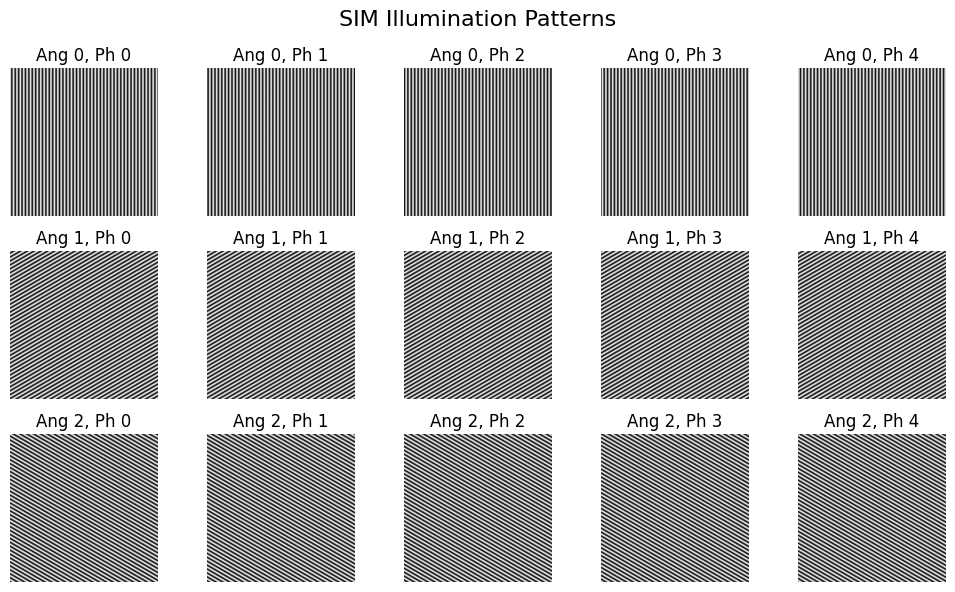

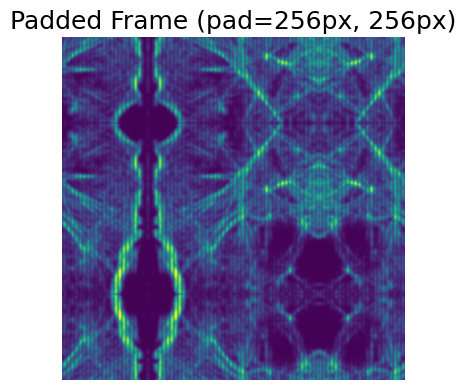

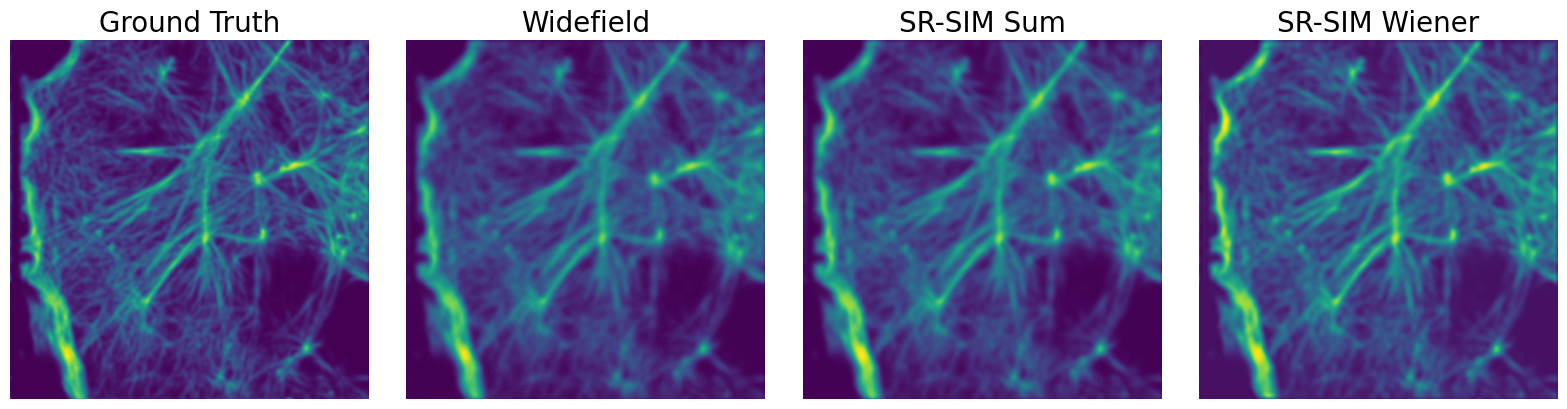

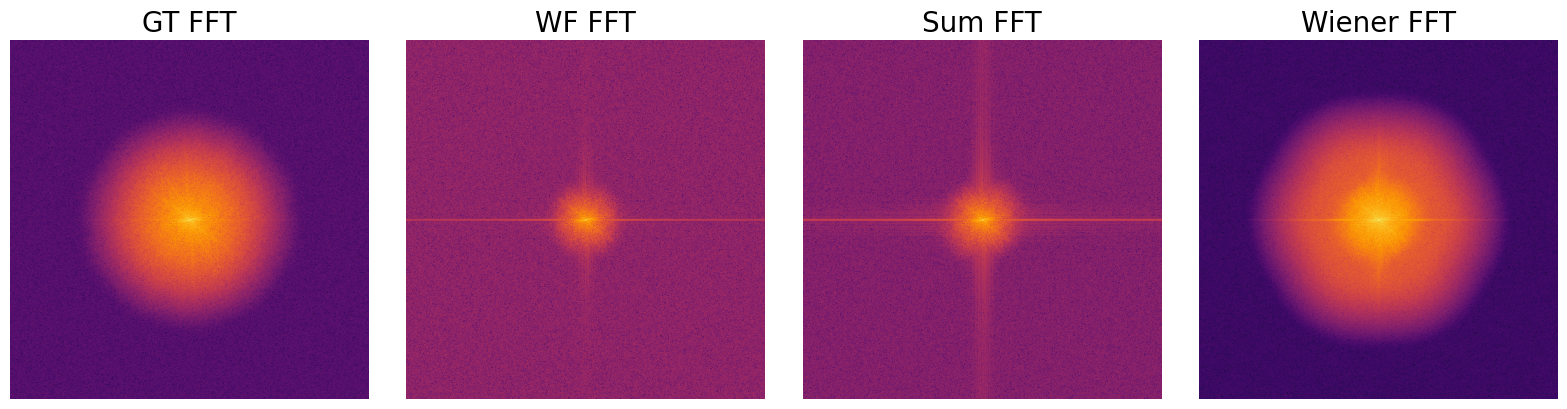

Noise-floor crossing (radial PSD):
  Widefield: 1.00x  (k = 123)
  SR-SIM Sum: 2.11x (k = 259)
  SR-SIM Wiener: 1.56x (k = 192)

FRC 1/2-bit cut-off:
  Widefield: 1/362 px (baseline)
  SR-SIM Sum: 1/257 px  -> 1.41x
  SR-SIM Wiener: 1/362 px  -> 1.00x


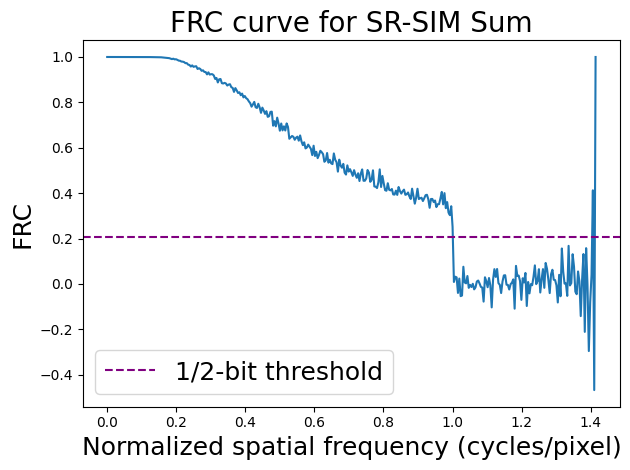

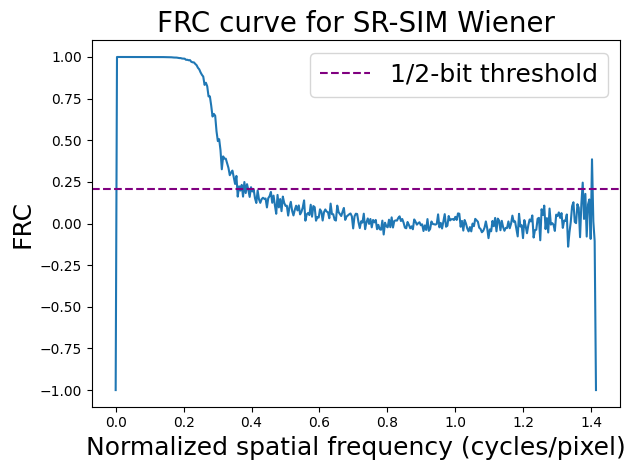

In [26]:
# Run pipeline once with example image
test = sim_pipeline('example_image.png', sigma_px=3, modulation=0.7, photons=50000, eps=0.1, display=True)

# **5. Statistically Significant Testing for my Pipeline**

In [18]:
# Function to repeat pipeline many times to get average test results that are statstically significant
def iterative_testing(image_path, sigma_px=2.0, modulation=0.8, num_angles=3, num_phases=5, gaussian_std=0.01, photons=50000, eps=0.01, iterations=50):

    # Lists to store metrics for each iteration
    k_wf_list = []
    k_sum_list = []
    k_wien_list = []
    k_wf_frc_list = []
    k_sum_frc_list = []
    k_wien_frc_list = []
    frc_curves_sum = []
    frc_curves_wien = []

    # Load ground truth
    gt = setup_and_load_image(image_path)
    # compute psf and sim patterns
    psf = define_psf(gt.shape, sigma_px)
    fc_px = 1/(np.pi * sigma_px)
    k_px = 0.8 * fc_px
    patterns = generate_sim_patterns(gt.shape, k_px, modulation, num_angles, num_phases)

    # Loop over iterations
    for _ in range(iterations):
        # Run full pipeline (display = false)
        res = sim_pipeline(image_path, sigma_px=sigma_px,
                           modulation=modulation,
                           num_angles=num_angles,
                           num_phases=num_phases,
                           gaussian_std=gaussian_std,
                           photons=photons,
                           eps=eps,
                           display=False)
        
        # Get radial PSD cut-offs
        k_wf, k_sum, k_wien = res['k_radial']
        k_wf_list.append(k_wf)
        k_sum_list.append(k_sum)
        k_wien_list.append(k_wien)

        # Get FRC cut-offs
        k_wf_frc, k_sum_frc, k_wien_frc = res['k_frc']
        k_wf_frc_list.append(k_wf_frc)
        k_sum_frc_list.append(k_sum_frc)
        k_wien_frc_list.append(k_wien_frc)

        # Compute full FRC curves on independent halves for curve averaging
        raw_A = simulate_sim_raw(gt, patterns, psf, gaussian_std, photons)
        raw_B = simulate_sim_raw(gt, patterns, psf, gaussian_std, photons)
        proc_A, *_ = preprocess_sim_frames(raw_A)
        proc_B, *_ = preprocess_sim_frames(raw_B)

        proc_A_pad, (py, px) = mirror_pad(proc_A, pad_frac=0.5)
        proc_B_pad, _ = mirror_pad(proc_B, pad_frac=0.5)
        psf_pad, _ = mirror_pad(psf, pad_frac=0.5)

        # Sum reconstruct both halves + remove padding
        sr_sum_A = simple_sim_reconstruct(proc_A_pad, k_px, psf_pad, num_angles=num_angles, num_phases=num_phases, modulation=modulation)[py:-py, px:-px]
        sr_sum_B = simple_sim_reconstruct(proc_B_pad, k_px, psf_pad, num_angles=num_angles, num_phases=num_phases, modulation=modulation)[py:-py, px:-px]
        
        # Wiener reconstruct both halves without any padding
        sr_wien_A = sim_reconstruct_wiener(proc_A, k_px, psf, num_angles=num_angles, num_phases=num_phases, modulation=modulation, eps=eps)
        sr_wien_B = sim_reconstruct_wiener(proc_B, k_px, psf, num_angles=num_angles, num_phases=num_phases, modulation=modulation, eps=eps)

        # Append FRC curves
        frc_curves_sum.append(frc(sr_sum_A, sr_sum_B))
        frc_curves_wien.append(frc(sr_wien_A, sr_wien_B))

    # Convert metric lists to numpy arrays
    k_wf_arr, k_sum_arr, k_wien_arr = map(np.array, (k_wf_list, k_sum_list, k_wien_list))
    k_wf_frc_arr, k_sum_frc_arr, k_wien_frc_arr = map(np.array,(k_wf_frc_list, k_sum_frc_list, k_wien_frc_list))
    frc_curves_sum = np.vstack(frc_curves_sum)
    frc_curves_wien = np.vstack(frc_curves_wien)

    # Average gains relative to WF
    avg_radial_gain_sum  = np.mean(k_sum_arr  / k_wf_arr)
    avg_radial_gain_wien = np.mean(k_wien_arr / k_wf_arr)
    avg_frc_gain_sum  = np.mean(k_wf_frc_arr / k_sum_frc_arr)
    avg_frc_gain_wien = np.mean(k_wf_frc_arr / k_wien_frc_arr)

    # Plot radial PSD results in histogram
    labels = ['Widefield', 'Sum', 'Wiener']
    gains_radial = [1.0, avg_radial_gain_sum, avg_radial_gain_wien]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(labels, gains_radial, color='purple')
    ax.set_ylabel('Resolution gain (x)', fontsize=18)
    ax.set_title('Average Noise‐Floor Crossing Gain', fontsize=18)
    ax.set_ylim(0, max(gains_radial)*1.1)
    ax.tick_params(axis='both', labelsize=16)
    plt.show()

    # Plot FRC results in histogram
    gains_frc = [1.0, avg_frc_gain_sum, avg_frc_gain_wien]
    plt.figure(figsize=(6,4))
    plt.bar(labels, gains_frc, color='purple')
    plt.ylabel('FRC 1/2-bit gain (x)', , fontsize=18)
    plt.title('Average FRC 1/2-bit Cutoff Gain', fontsize=18)
    plt.ylim(0, max(gains_frc)*1.1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

    # Plot average FRC curves
    avg_curve_sum  = frc_curves_sum.mean(axis=0)
    avg_curve_wien = frc_curves_wien.mean(axis=0)
    Ny, Nx = gt.shape
    freq = np.arange(avg_curve_sum.size) / (min(Ny, Nx) / 2)
    plt.figure(figsize=(9,6))
    plt.plot(freq, avg_curve_sum, label='Sum')
    plt.plot(freq, avg_curve_wien, label='Wiener')
    plt.axhline(0.2071, linestyle='--', color='gray', label='1/2-bit thresh.')
    plt.xlabel('Normalized spatial frequency', fontsize=12)
    plt.ylabel('FRC', fontsize=12)
    plt.title('Average FRC Curves', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print results
    print('Average Noise‐Floor Crossing Gains (x):')
    print(f'  Widefield:     {1.0:.2f}x')
    print(f'  SR-SIM Sum:    {avg_radial_gain_sum:.2f}x')
    print(f'  SR-SIM Wiener: {avg_radial_gain_wien:.2f}x')
    print('\nAverage FRC 1/2-bit Cutoff Gains (x):')
    print(f'  Widefield:     {1.0:.2f}x')
    print(f'  SR-SIM Sum:    {avg_frc_gain_sum:.2f}x')
    print(f'  SR-SIM Wiener: {avg_frc_gain_wien:.2f}x')
    
    # return final results
    return {
        'avg_radial_gain':  (1.0, avg_radial_gain_sum, avg_radial_gain_wien),
        'avg_frc_gain':     (1.0, avg_frc_gain_sum, avg_frc_gain_wien),
        'avg_curve_sum':    avg_curve_sum,
        'avg_curve_wien':   avg_curve_wien
    }


SyntaxError: invalid syntax (3643235004.py, line 95)

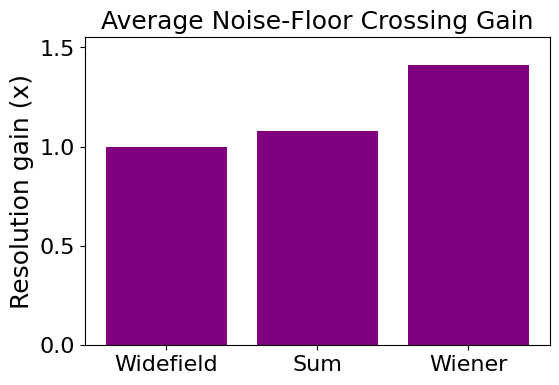

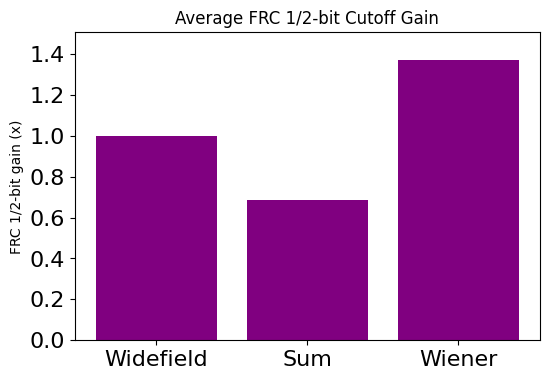

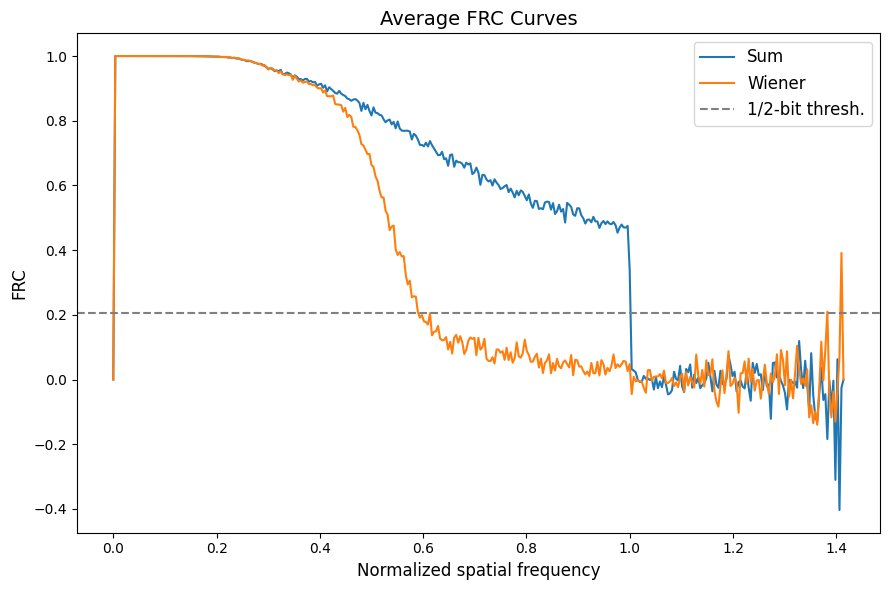

Average Noise‐Floor Crossing Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    1.08x
  SR-SIM Wiener: 1.41x

Average FRC 1/2-bit Cutoff Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    0.69x
  SR-SIM Wiener: 1.37x


In [19]:
# Run N tests and give average results
example_results2 = iterative_testing('example_image.png', sigma_px=1.5, modulation=0.7, num_angles=3, num_phases=5, gaussian_std=0.01, photons=50000, eps=0.1, iterations=2)

### **4.4 Grid Search for best SIM Parameters**

Average Noise‐Floor Crossing Gains (×):
  Widefield:     1.00×
  SR-SIM Sum:    1.11×
  SR-SIM Wiener: 1.44×

Average FRC ½-bit Cutoff Gains (×):
  Widefield:     1.00×
  SR-SIM Sum:    0.90×
  SR-SIM Wiener: 1.34×

In [23]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

def grid_search_testing(image_path, parameter_grid, iterations_per_combination):
    # make lists of parameter names and their values
    names, lists = zip(*parameter_grid.items())
    # store the best gain we've seen so far
    best_gain = -np.inf
    # store the settings for the best gain
    best_params = None
    # store the detailed results for the best gain
    best_results = None

    # go over every possible combination of hyperparameters
    for vals in product(*lists):
        # build a dict of the current settings
        params = dict(zip(names, vals))
        print(f"\nTesting {params} ...", end=" ")

        # switch off interactive plotting so it stays quiet
        plt.ioff()
        try:
            # run the test many times to get average metrics
            res = iterative_testing(
                image_path,
                sigma_px     = params.get('sigma_px',     2.0),
                modulation   = params.get('modulation',   0.8),
                num_angles   = params.get('num_angles',   3),
                num_phases   = params.get('num_phases',   5),
                gaussian_std = params.get('gaussian_std', 0.01),
                photons      = params.get('photons',      1e4),
                eps          = params.get('eps',          0.01),
                iterations   = iterations_per_combination
            )
        finally:
            # always turn plotting back on and close extra figures
            plt.ion()
            plt.close('all')

        # pick the Wiener FRC gain from the results (3rd element)
        wiener_gain = res['avg_frc_gain'][2]
        print(f"gain={wiener_gain:.3f}x")

        # if this is the best gain so far, keep it
        if wiener_gain > best_gain:
            best_gain    = wiener_gain
            best_params  = params
            best_results = res

    # after checking all combos, show which was best
    print(f"\nBest parameter set:\n  {best_params}\n  → Wiener FRC gain = {best_gain:.3f}x")

    # give back the best settings and their results
    return best_params, best_results


Testing {'sigma_px': 1.5, 'modulation': 0.5, 'num_angles': 3, 'num_phases': 5, 'gaussian_std': 0.01, 'photons': 50000.0, 'eps': 0.01} ... 

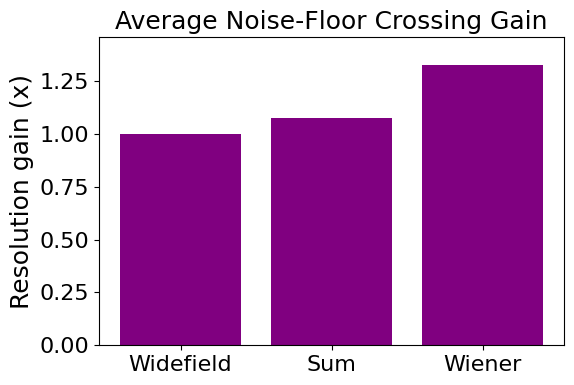

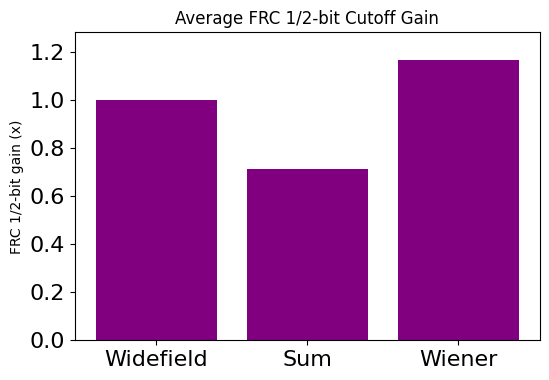

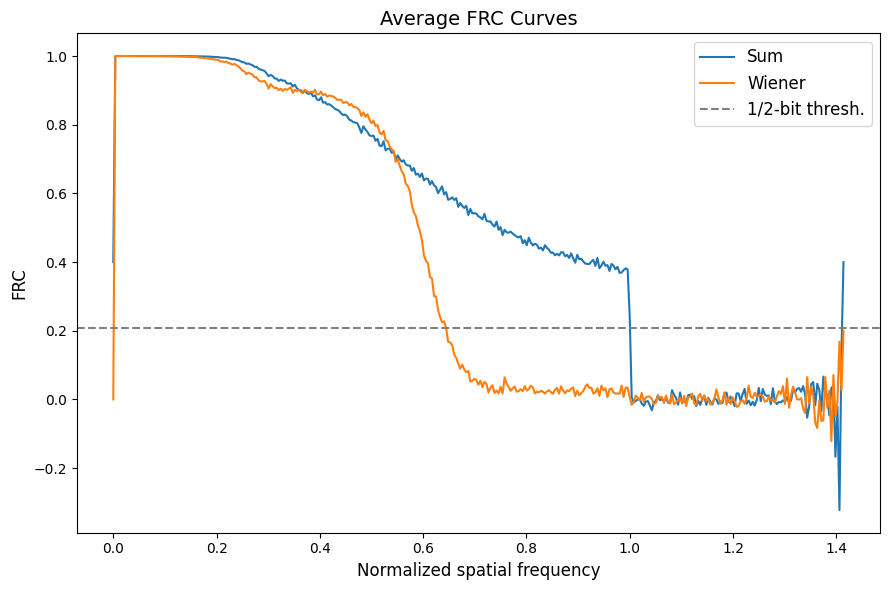

Average Noise‐Floor Crossing Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    1.08x
  SR-SIM Wiener: 1.32x

Average FRC 1/2-bit Cutoff Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    0.71x
  SR-SIM Wiener: 1.17x
gain=1.167x

Testing {'sigma_px': 1.5, 'modulation': 0.5, 'num_angles': 3, 'num_phases': 5, 'gaussian_std': 0.01, 'photons': 50000.0, 'eps': 0.1} ... 

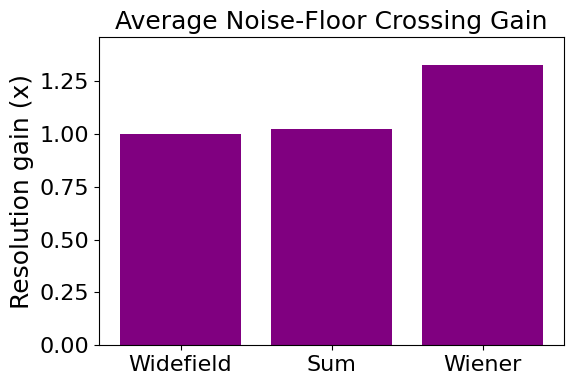

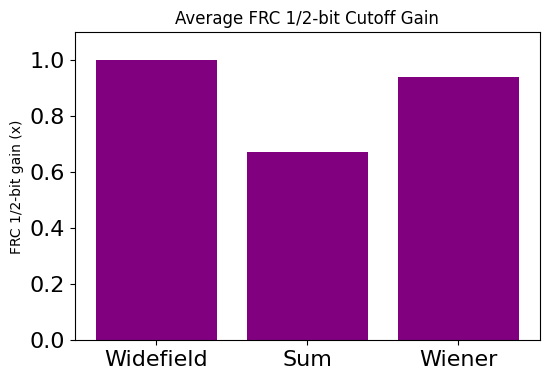

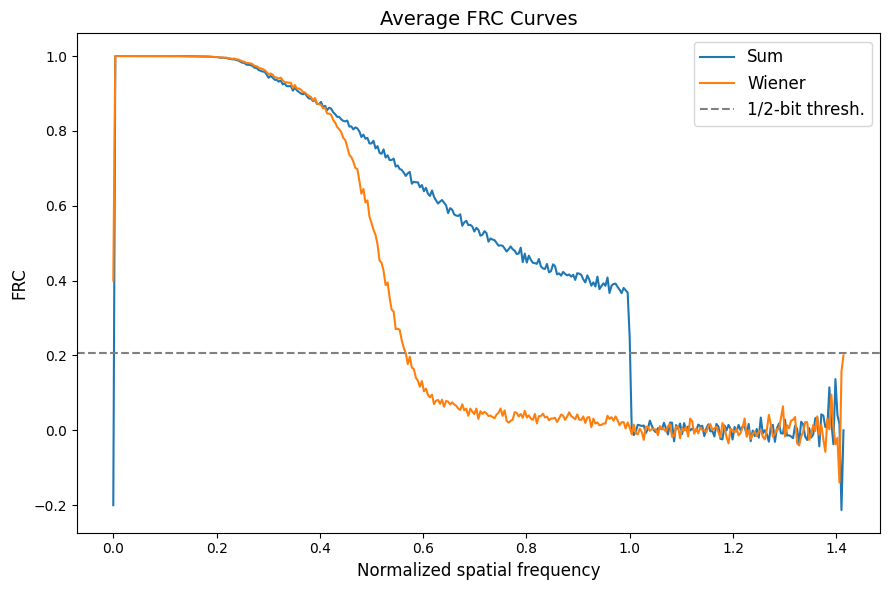

Average Noise‐Floor Crossing Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    1.02x
  SR-SIM Wiener: 1.32x

Average FRC 1/2-bit Cutoff Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    0.67x
  SR-SIM Wiener: 0.94x
gain=0.942x

Testing {'sigma_px': 1.5, 'modulation': 0.7, 'num_angles': 3, 'num_phases': 5, 'gaussian_std': 0.01, 'photons': 50000.0, 'eps': 0.01} ... 

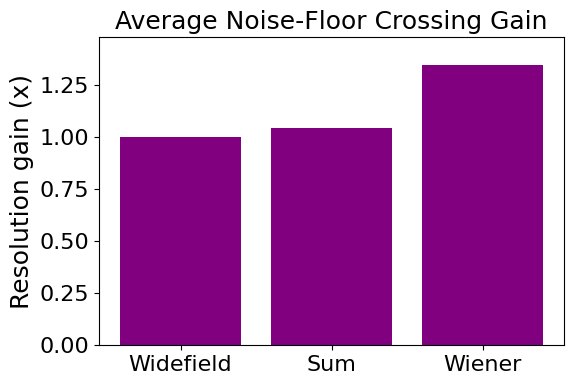

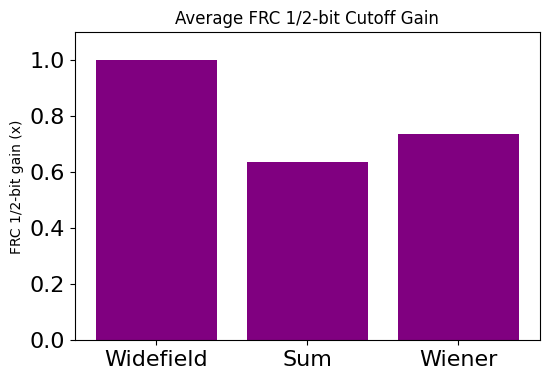

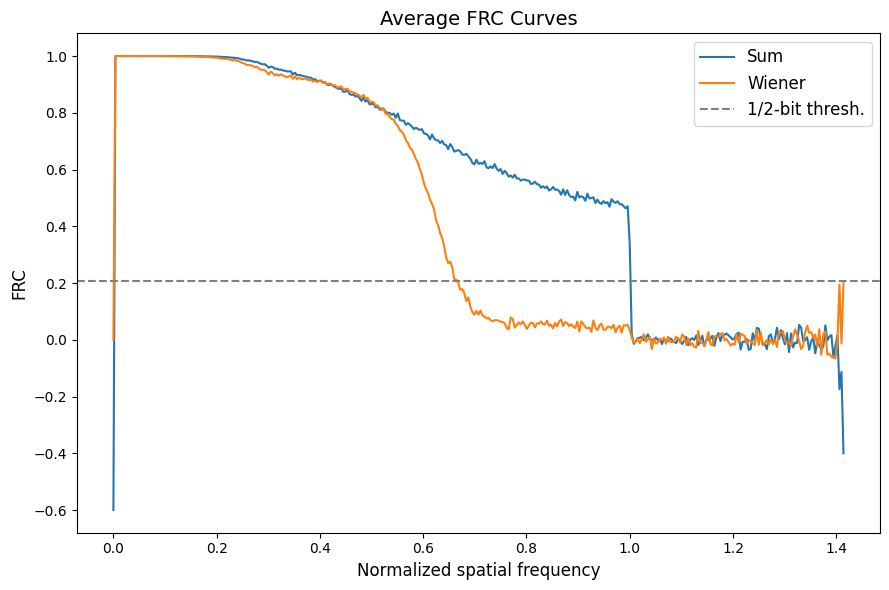

Average Noise‐Floor Crossing Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    1.04x
  SR-SIM Wiener: 1.34x

Average FRC 1/2-bit Cutoff Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    0.64x
  SR-SIM Wiener: 0.74x
gain=0.738x

Testing {'sigma_px': 1.5, 'modulation': 0.7, 'num_angles': 3, 'num_phases': 5, 'gaussian_std': 0.01, 'photons': 50000.0, 'eps': 0.1} ... 

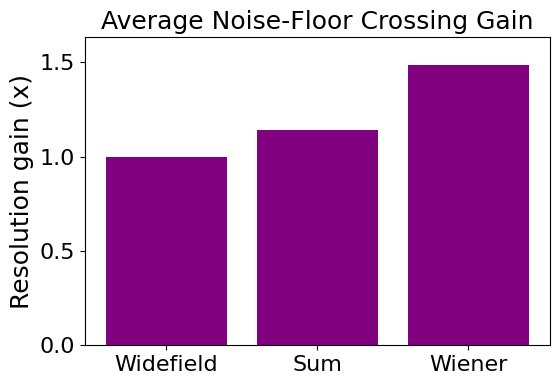

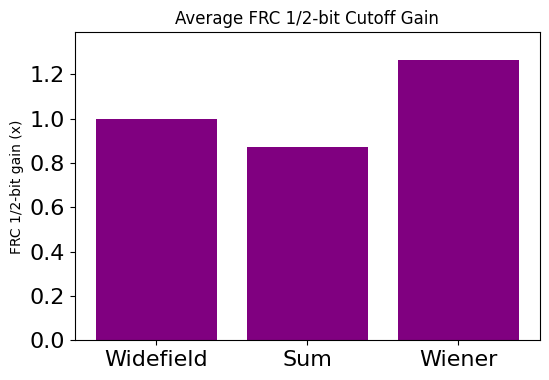

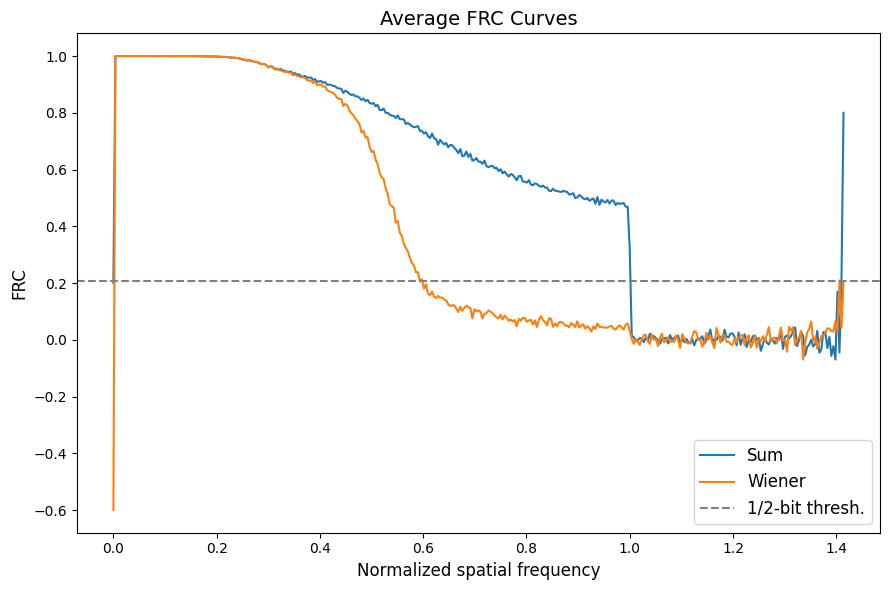

Average Noise‐Floor Crossing Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    1.14x
  SR-SIM Wiener: 1.48x

Average FRC 1/2-bit Cutoff Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    0.87x
  SR-SIM Wiener: 1.26x
gain=1.264x

Testing {'sigma_px': 1.5, 'modulation': 0.9, 'num_angles': 3, 'num_phases': 5, 'gaussian_std': 0.01, 'photons': 50000.0, 'eps': 0.01} ... 

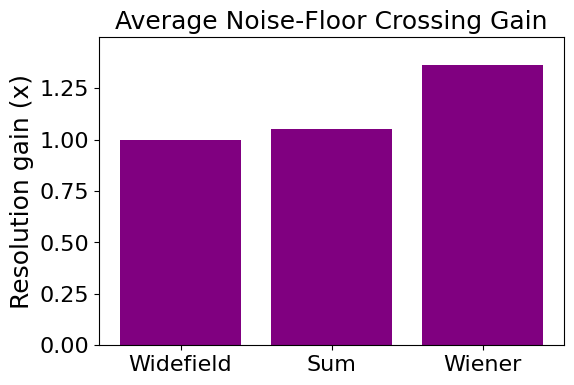

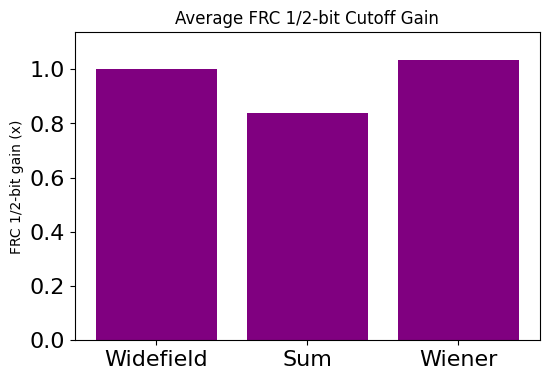

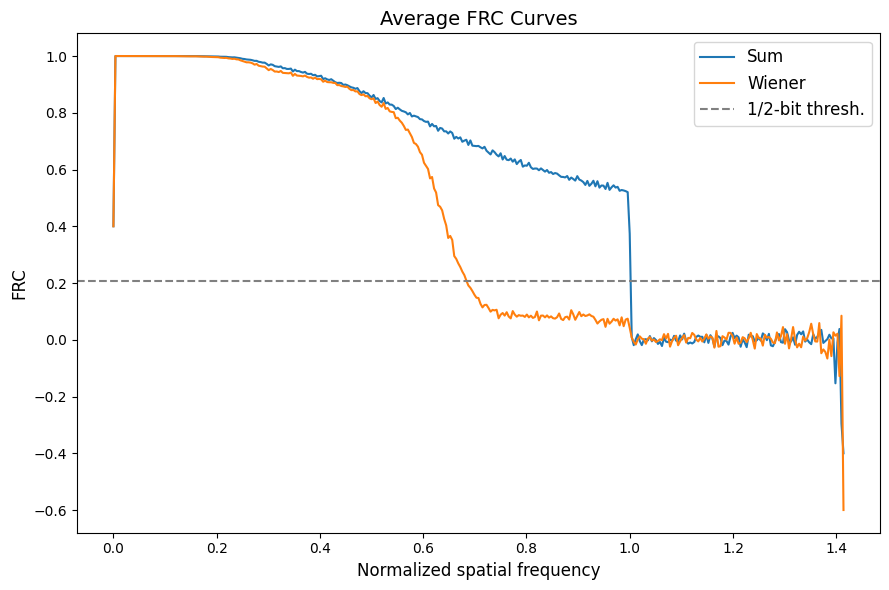

Average Noise‐Floor Crossing Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    1.05x
  SR-SIM Wiener: 1.36x

Average FRC 1/2-bit Cutoff Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    0.84x
  SR-SIM Wiener: 1.03x
gain=1.033x

Testing {'sigma_px': 1.5, 'modulation': 0.9, 'num_angles': 3, 'num_phases': 5, 'gaussian_std': 0.01, 'photons': 50000.0, 'eps': 0.1} ... 

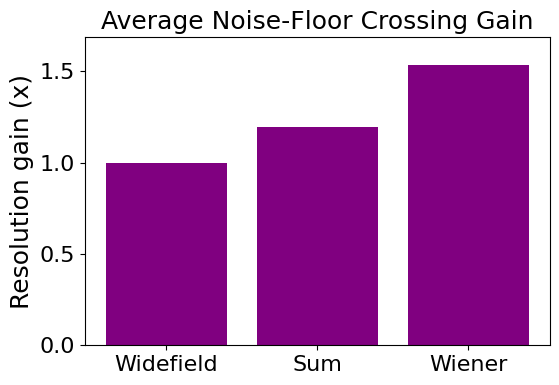

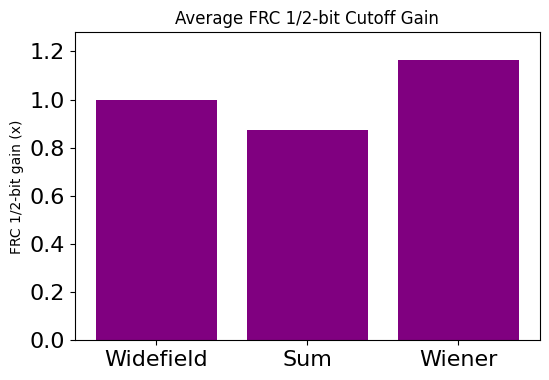

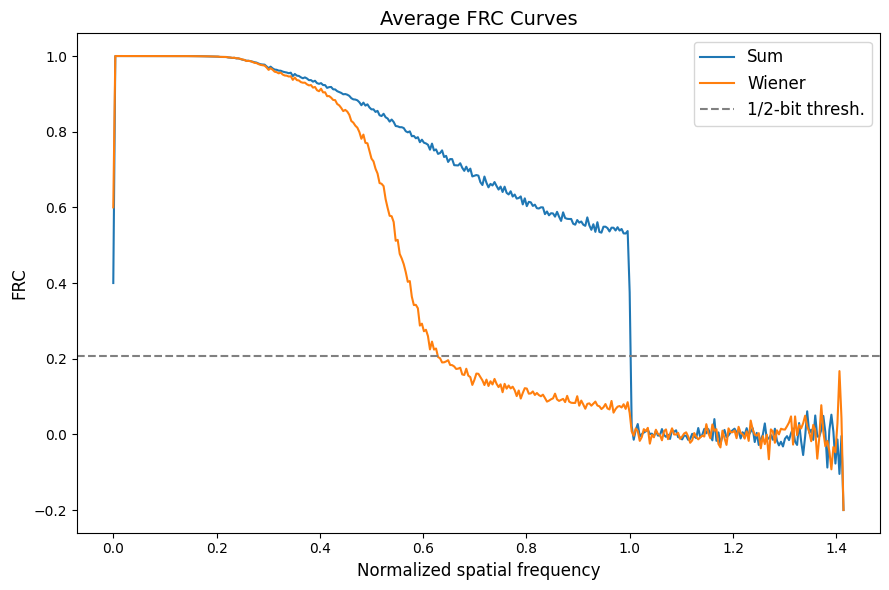

Average Noise‐Floor Crossing Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    1.20x
  SR-SIM Wiener: 1.53x

Average FRC 1/2-bit Cutoff Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    0.87x
  SR-SIM Wiener: 1.16x
gain=1.163x

Testing {'sigma_px': 2.0, 'modulation': 0.5, 'num_angles': 3, 'num_phases': 5, 'gaussian_std': 0.01, 'photons': 50000.0, 'eps': 0.01} ... 

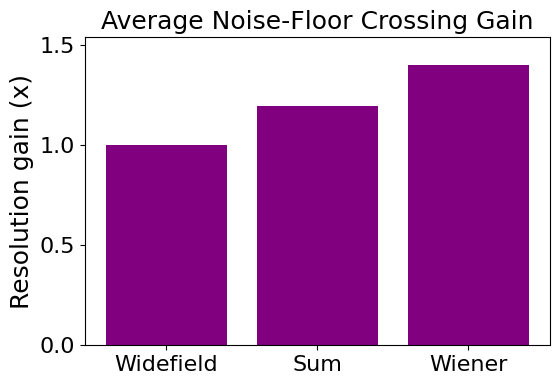

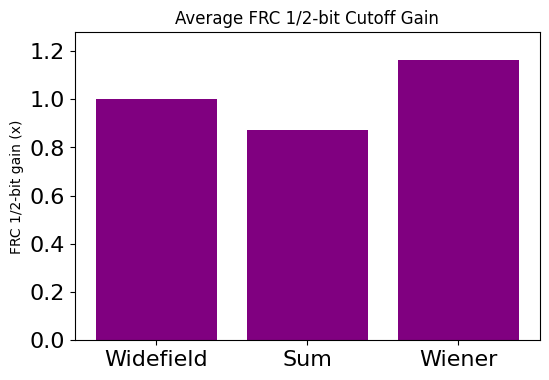

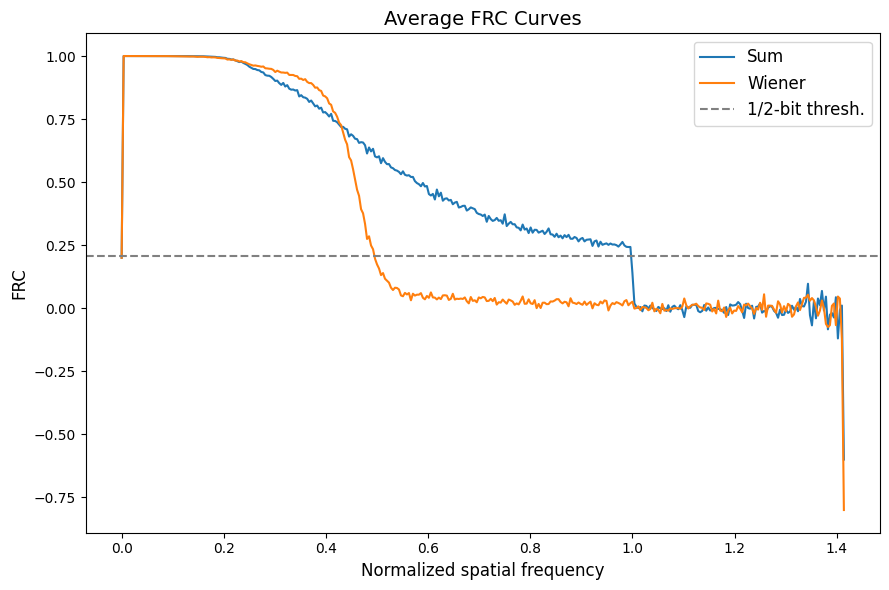

Average Noise‐Floor Crossing Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    1.19x
  SR-SIM Wiener: 1.40x

Average FRC 1/2-bit Cutoff Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    0.87x
  SR-SIM Wiener: 1.16x
gain=1.162x

Testing {'sigma_px': 2.0, 'modulation': 0.5, 'num_angles': 3, 'num_phases': 5, 'gaussian_std': 0.01, 'photons': 50000.0, 'eps': 0.1} ... 

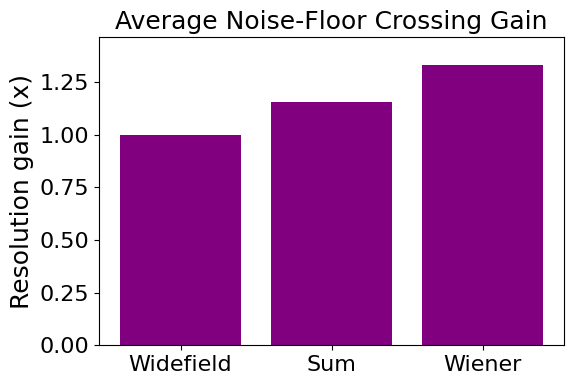

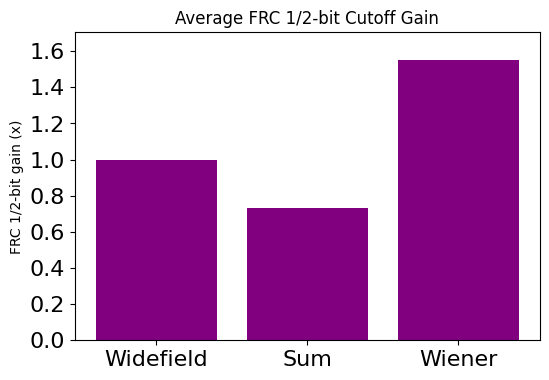

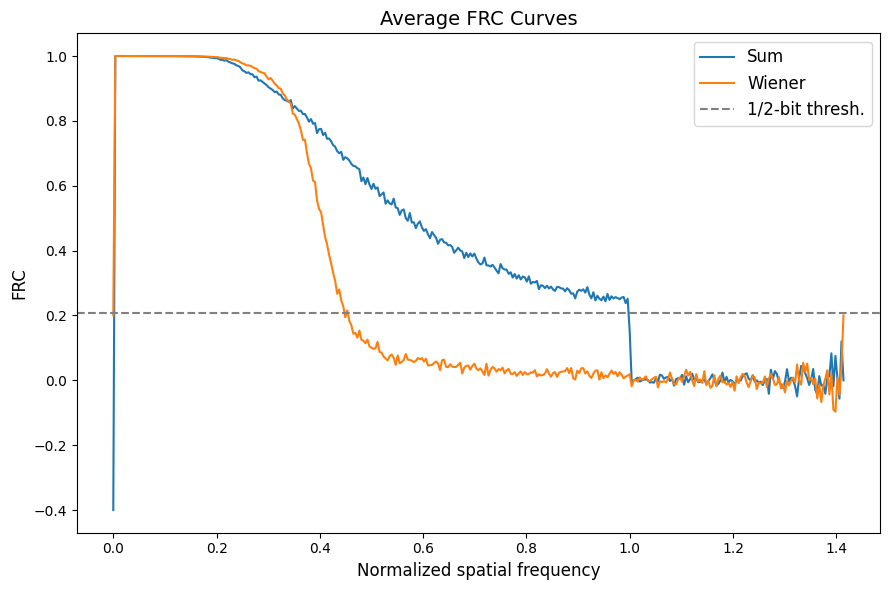

Average Noise‐Floor Crossing Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    1.16x
  SR-SIM Wiener: 1.33x

Average FRC 1/2-bit Cutoff Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    0.73x
  SR-SIM Wiener: 1.55x
gain=1.550x

Testing {'sigma_px': 2.0, 'modulation': 0.7, 'num_angles': 3, 'num_phases': 5, 'gaussian_std': 0.01, 'photons': 50000.0, 'eps': 0.01} ... 

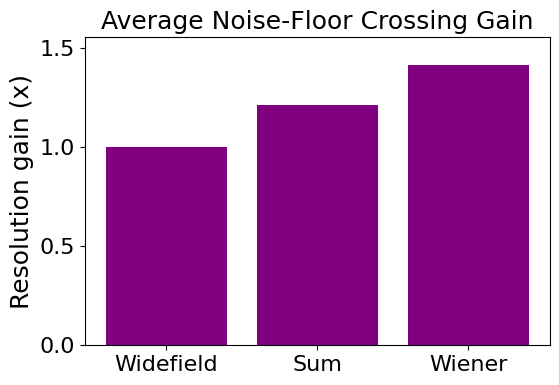

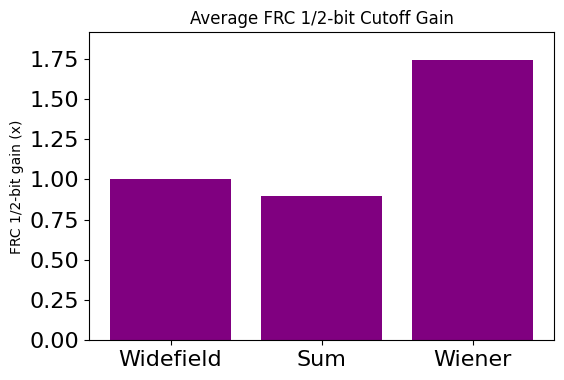

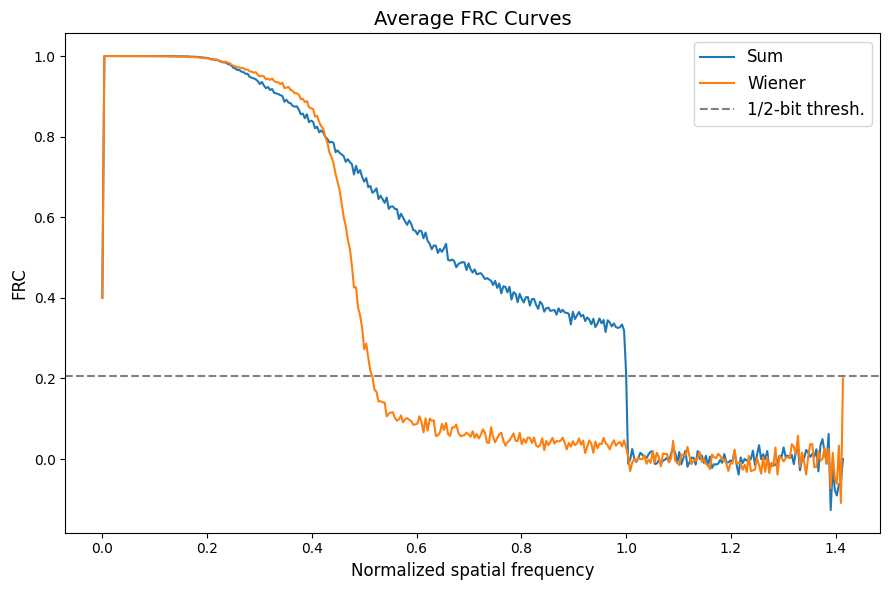

Average Noise‐Floor Crossing Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    1.21x
  SR-SIM Wiener: 1.41x

Average FRC 1/2-bit Cutoff Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    0.90x
  SR-SIM Wiener: 1.74x
gain=1.741x

Testing {'sigma_px': 2.0, 'modulation': 0.7, 'num_angles': 3, 'num_phases': 5, 'gaussian_std': 0.01, 'photons': 50000.0, 'eps': 0.1} ... 

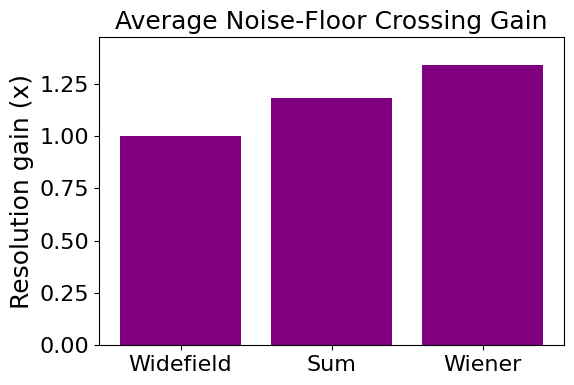

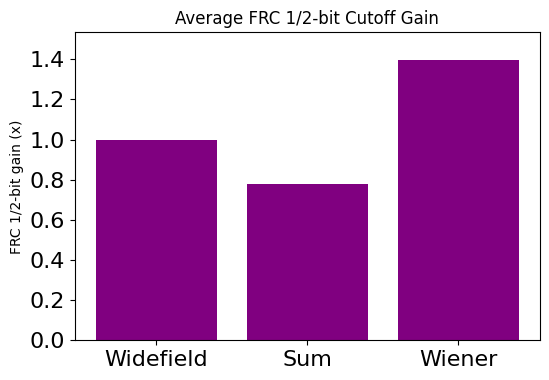

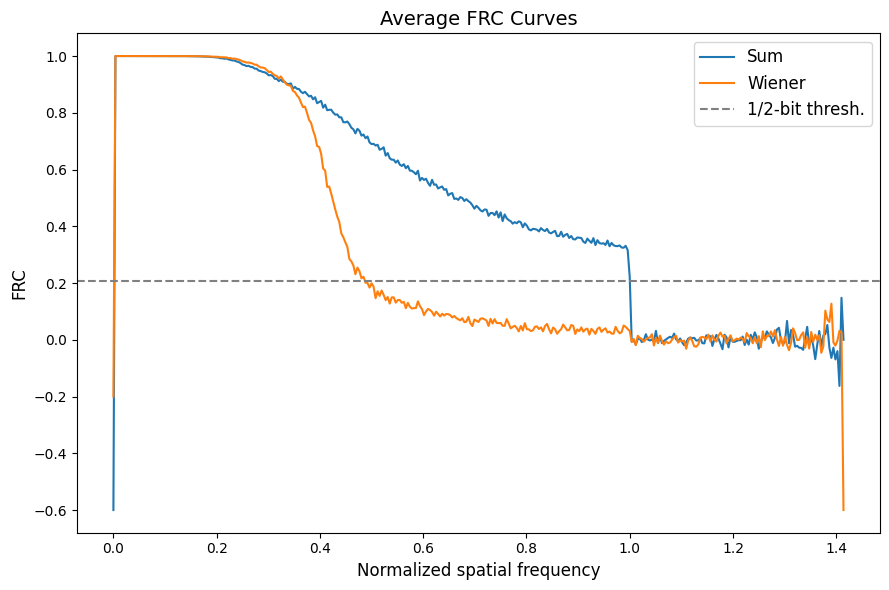

Average Noise‐Floor Crossing Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    1.18x
  SR-SIM Wiener: 1.34x

Average FRC 1/2-bit Cutoff Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    0.78x
  SR-SIM Wiener: 1.40x
gain=1.395x

Testing {'sigma_px': 2.0, 'modulation': 0.9, 'num_angles': 3, 'num_phases': 5, 'gaussian_std': 0.01, 'photons': 50000.0, 'eps': 0.01} ... 

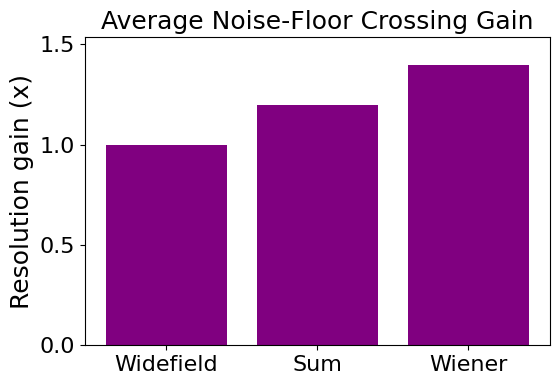

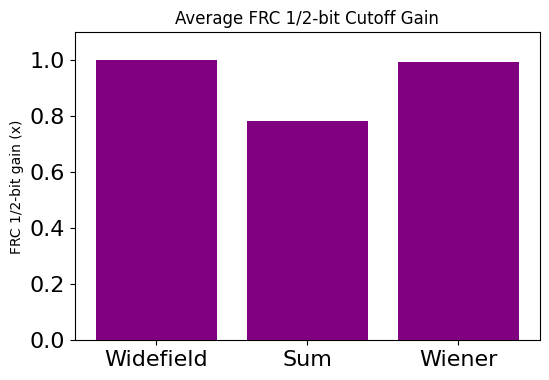

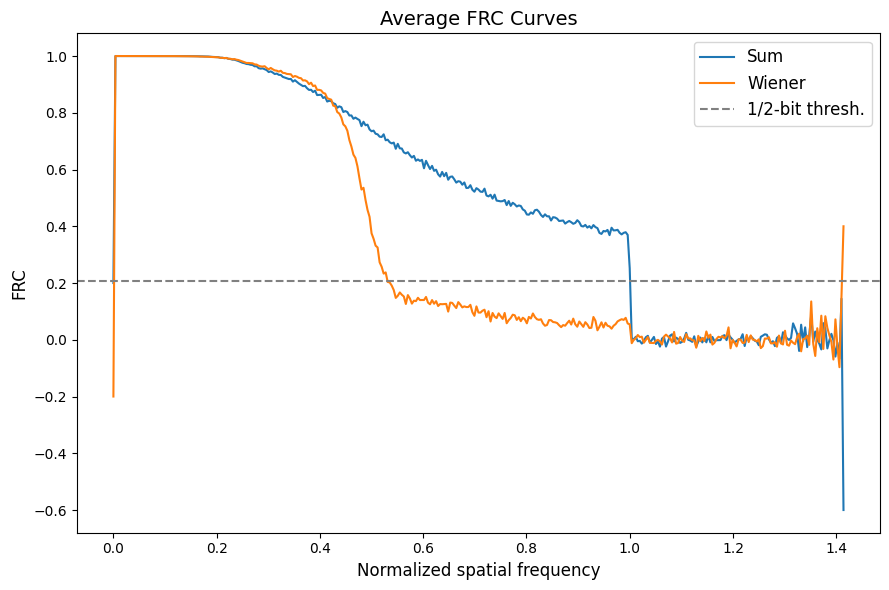

Average Noise‐Floor Crossing Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    1.20x
  SR-SIM Wiener: 1.39x

Average FRC 1/2-bit Cutoff Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    0.78x
  SR-SIM Wiener: 0.99x
gain=0.995x

Testing {'sigma_px': 2.0, 'modulation': 0.9, 'num_angles': 3, 'num_phases': 5, 'gaussian_std': 0.01, 'photons': 50000.0, 'eps': 0.1} ... 

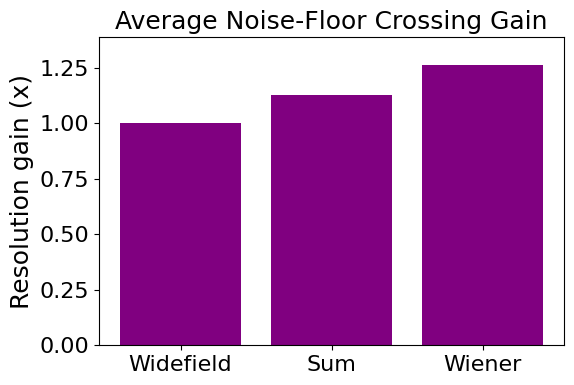

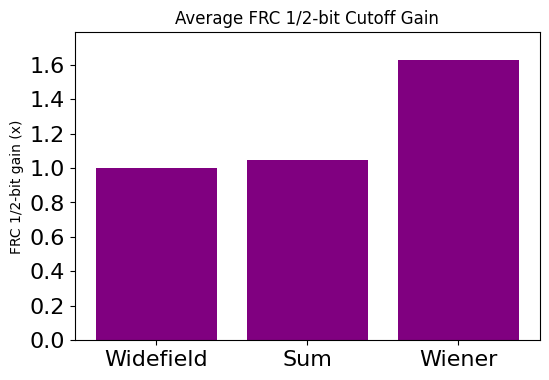

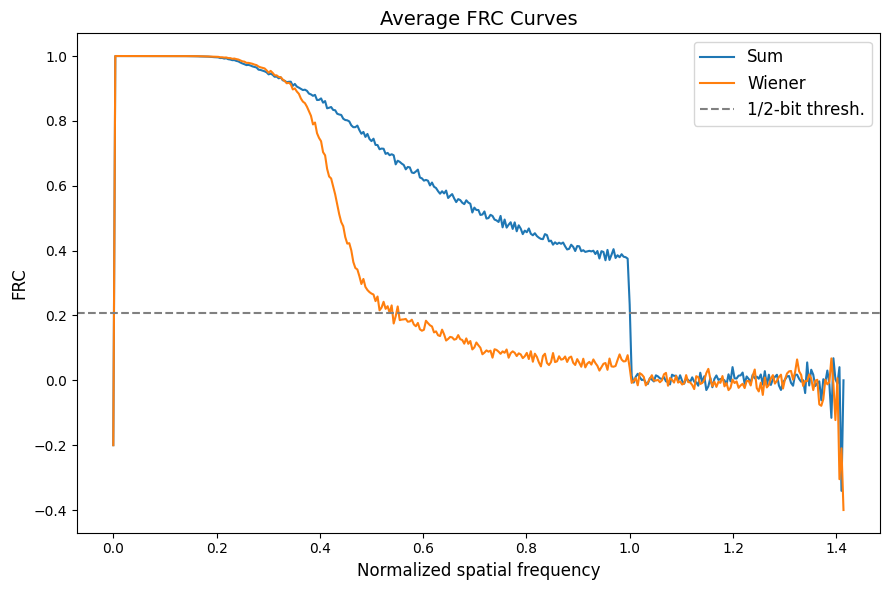

Average Noise‐Floor Crossing Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    1.13x
  SR-SIM Wiener: 1.26x

Average FRC 1/2-bit Cutoff Gains (x):
  Widefield:     1.00x
  SR-SIM Sum:    1.05x
  SR-SIM Wiener: 1.63x
gain=1.625x

Best parameter set:
  {'sigma_px': 2.0, 'modulation': 0.7, 'num_angles': 3, 'num_phases': 5, 'gaussian_std': 0.01, 'photons': 50000.0, 'eps': 0.01}
  → Wiener FRC gain = 1.741x
Best = {'sigma_px': 2.0, 'modulation': 0.7, 'num_angles': 3, 'num_phases': 5, 'gaussian_std': 0.01, 'photons': 50000.0, 'eps': 0.01}


In [ ]:
param_grid = {
    'sigma_px':     [1.5, 2.0],
    'modulation':   [0.5, 0.7, 0.9],
    'num_angles':   [3],
    'num_phases':   [5],
    'gaussian_std': [0.01],
    'photons':      [5e4],
    'eps':          [0.01, 0.1],
}

best_params, best_results = grid_search_testing('example_image.png', param_grid, iterations_per_combination=25
)
print("Best =", best_params)